## Table of Contents <a id='toc'></a>

1. [Overview & Objectives](#overview)
2. [Setup & Imports](#setup)
3. [Data Loading](#data-loading)
4. [Data Profiling & Exploratory Data Analysis (EDA)](#eda)
5. [Data Cleaning & Preprocessing](#cleaning)
   - 5.1 Missing Values  
   - 5.2 Type Conversion  
   - 5.3 Outlier Handling  
6. [Feature Engineering](#fe)
   - 6.1 Rolling Statistics (Time-Domain)  
   - 6.2 Trend Features (Slopes, Deltas)  
   - 6.3 Frequency-Domain Features (FFT)  
   - 6.4 Lag Features  
7. [Feature Selection](#feature-selection)
   - 7.1 Variance Threshold  
   - 7.2 SelectKBest  
   - 7.3 Tree-based Feature Importance  
8. [Train/Validation/Test Split (Time-Based)](#split)
9. [Modeling Pipeline & Preprocessing](#pipeline)
10. [Model Training & Hyperparameter Tuning](#tuning)
11. [Evaluation & Metrics](#evaluation)
    - 11.1 Confusion Matrix  
    - 11.2 ROC & PR Curves  
    - 11.3 Horizon-wise Performance Decay  
12. [Feature Importance & Explainability](#fi)
13. [Model Persistence & Deployment](#deploy)
14. [Basic Monitoring (Data Drift & PSI)](#monitoring)
15. [Appendix: Utility Functions](#appendix-utils)
16. [Appendix: Original Notebook (Unmodified)](#appendix-original)

# ## 1) Overview & Objectives <a id='overview'></a>
This notebook implements a **production-ready predictive maintenance pipeline** for centrifugal water pumps.  
**Variables:**  
- `Time` (timestamp)  
- `flow`, `pressure`, `level`  
- `NDE_motor`, `DE_motor`, `DE_pump`, `NDE_pump`, `Coupling` (vibration channels)  
- `status` (target label: Normal/Warning/Critical/Failure)  
- `pump` (categorical pump identifier)  

**Design Principles:**  
- Keep outliers — they often indicate faults  
- Time-aware train/validation/test splits  
- Sklearn Pipeline for reproducibility  
- Clear metrics: Precision/Recall/F1, ROC-AUC, PR curves  
- Model persistence and monitoring

## 2) Setup & Imports <a id='setup'></a>
Load required packages for data manipulation, visualization, modeling, imbalance handling, and deployment.

In [1]:
# Core
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,auc
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder,label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight

# Classifiers
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Signal processing
from scipy.fft import rfft, rfftfreq

# Model persistence
import joblib

# Explainability
import shap

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)


## 3) Data Loading <a id='data-loading'></a>
Load raw CSV data, preview columns and rows, and get a general overview of the dataset.


In [2]:
# Path to raw file (adjust if needed)
raw_data_path = "raw_data.csv"

# Load dataset
print(f"Loading dataset from: {raw_data_path} ...")
raw_data = pd.read_csv(raw_data_path, low_memory=False)

# Basic overview
print("\n Dataset loaded successfully!")
print(f"Shape: {raw_data.shape[0]} rows × {raw_data.shape[1]} columns")
print("\nColumns:\n", raw_data.columns.tolist()[:20], "..." if raw_data.shape[1] > 20 else "")

Loading dataset from: raw_data.csv ...

 Dataset loaded successfully!
Shape: 2902703 rows × 11 columns

Columns:
 ['Time', 'flow', 'pressure', 'level', 'NDE_motor', 'DE_motor', 'DE_pump', 'NDE_pump', 'Coupling', 'status', 'pump'] 


In [3]:
# Peek at first rows
print("\nView first 5 rows in dataset:\n")
display(raw_data.head())


View first 5 rows in dataset:



Time  flow  pressure level  NDE_motor  DE_motor   DE_pump  NDE_pump  Coupling       status           pump
0  2024-07-01 00:00:00   7.0      14.0   4.0   1.425895  0.809613  1.515767  1.925454  1.712472  OPERATIONAL  Katosi_pump_A
1  2024-07-01 00:00:01   7.0      14.0   4.0   1.705083  0.938638  1.271483  1.470059  1.474253  OPERATIONAL  Katosi_pump_A
2  2024-07-01 00:00:02   7.0      14.0   4.0   1.696127  0.858741  1.250857  0.981875  1.296959  OPERATIONAL  Katosi_pump_A
3  2024-07-01 00:00:03   7.0      14.0   4.0   1.375684  0.864957  1.199183  0.816708  1.345098  OPERATIONAL  Katosi_pump_A
4  2024-07-01 00:00:20   7.0      14.0   4.0   1.117979  1.178480  1.172442  0.948706  1.399022  OPERATIONAL  Katosi_pump_A

## 4) Data Profiling & Exploratory Data Analysis (EDA) <a id='eda'></a>
Inspect missingness, feature distributions, and quick signal plots.  
Visualize pump-level utilization, status distribution, and potential maintenance priorities.


In [4]:
sensors = ['flow', 'pressure', 'level', 'NDE_motor', 'DE_motor', 'DE_pump',
       'NDE_pump', 'Coupling']
date_column = 'Time' 
statuses = ['OPERATIONAL', 'OFF', 'CHANGE', 'WARNING', 'CRITICAL']

In [5]:
# Generate encoding maps for labels
label2id = {l: i for i,l in enumerate(statuses)}
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'OPERATIONAL', 1: 'OFF', 2: 'CHANGE', 3: 'WARNING', 4: 'CRITICAL'}

In [6]:
# Generate encoded labels
#df_clean['status_encoded'] = df_clean['status'].map(label2id)

In [7]:
# Quick info
print("\n--- Dataset Info ---")
raw_data.info(show_counts=True)


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2902703 entries, 0 to 2902702
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Time       2902701 non-null  object 
 1   flow       2902701 non-null  float64
 2   pressure   2902701 non-null  float64
 3   level      2902703 non-null  object 
 4   NDE_motor  2902703 non-null  float64
 5   DE_motor   2902703 non-null  float64
 6   DE_pump    2902703 non-null  float64
 7   NDE_pump   2902703 non-null  float64
 8   Coupling   2902703 non-null  float64
 9   status     2902703 non-null  object 
 10  pump       2902703 non-null  object 
dtypes: float64(7), object(4)
memory usage: 243.6+ MB


<div class="alert alert-block alert-info">
<br>
<h4>What is observed</h4>
The dataset is very large: ~2.9 million rows → ~244 MB in memory.

Some columns (Time, level) are object type instead of numeric/datetime, which need cleaning/conversion.

We observe that there are missing values within the dataset.
</div>


### cleaning up the Time and level valuables 

In [8]:
# Ensure 'Time' is a datetime column
raw_data["Time"] = pd.to_datetime(raw_data["Time"], errors="coerce")

# Convert the column to float, setting non-numeric values to NaN
raw_data['level'] = pd.to_numeric(raw_data['level'], errors="coerce")

### checking missing values with percentages

In [9]:
# Count missing values and percentage
missing = raw_data.isnull().sum()
missing_percent = (missing / len(raw_data)) * 100

# Combine into a DataFrame for clarity
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage (%)': missing_percent.round(2)
})

print(missing_df)


           Missing Values  Percentage (%)
Time                    2            0.00
flow                    2            0.00
pressure                2            0.00
level                 597            0.02
NDE_motor               0            0.00
DE_motor                0            0.00
DE_pump                 0            0.00
NDE_pump                0            0.00
Coupling                0            0.00
status                  0            0.00
pump                    0            0.00


since the % of the mising data is too small, Dropping these rows is the simplest, cleanest, and most reliable approach, ensuring data integrity without affecting model performance.

In [10]:
raw_data[sensors] = raw_data[sensors].fillna(method="ffill").fillna(method="bfill")
raw_data = raw_data.dropna(subset=["Time", "status"])
print(f"After cleaning: {raw_data.shape}")


After cleaning: (2902701, 11)


### Missing Value Report 

In [11]:
missing_df = raw_data.isnull().mean().mul(100).round(2).reset_index()
missing_df.columns = ["Feature", "Missing %"]
print(missing_df.head())

     Feature  Missing %
0       Time        0.0
1       flow        0.0
2   pressure        0.0
3      level        0.0
4  NDE_motor        0.0


In [12]:
# Quick signal plots
def quick_plot(ts_df, cols, n=2000, title="Quick Signals"):
    subset = ts_df.iloc[:min(n, len(ts_df))]
    plt.figure(figsize=(15, 5))
    for c in cols:
        plt.plot(subset["Time"], subset[c], label=c)
    plt.title(title)
    plt.xlabel("Time")
    plt.legend()
    plt.show()

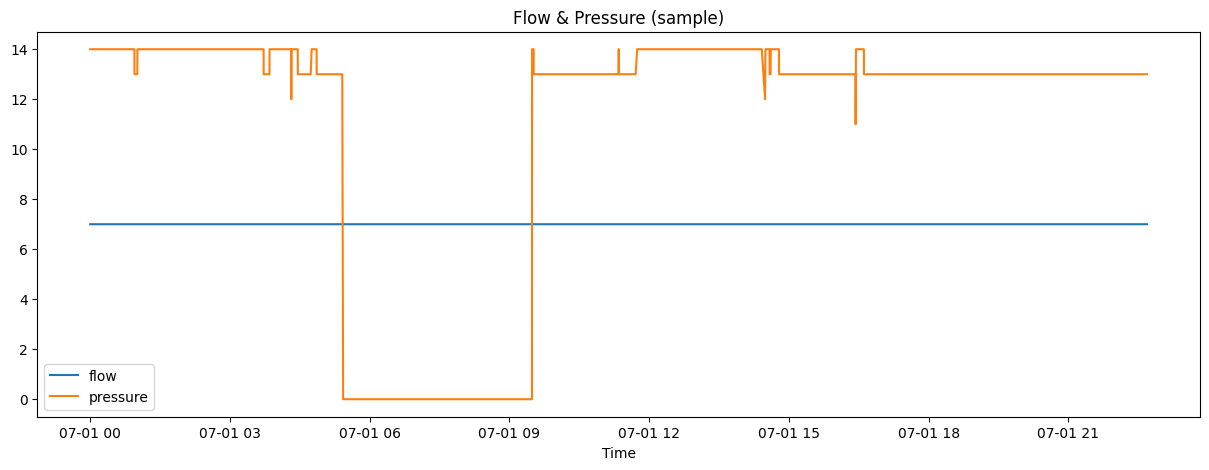

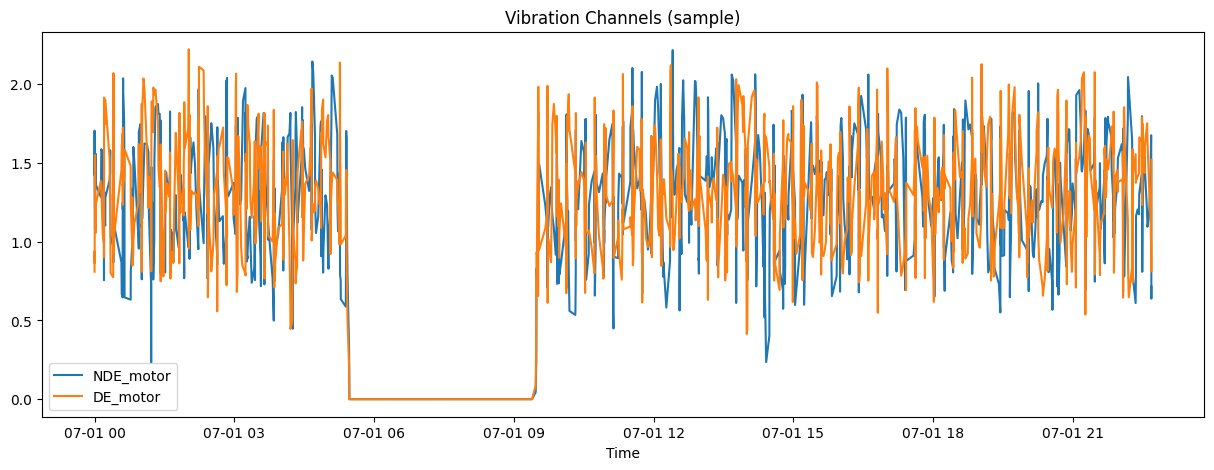

In [13]:
quick_plot(raw_data, ["flow", "pressure"], title="Flow & Pressure (sample)")
quick_plot(raw_data, ["NDE_motor", "DE_motor"], title="Vibration Channels (sample)")

<a id='1.3'></a>
## View distribution of machine status labels

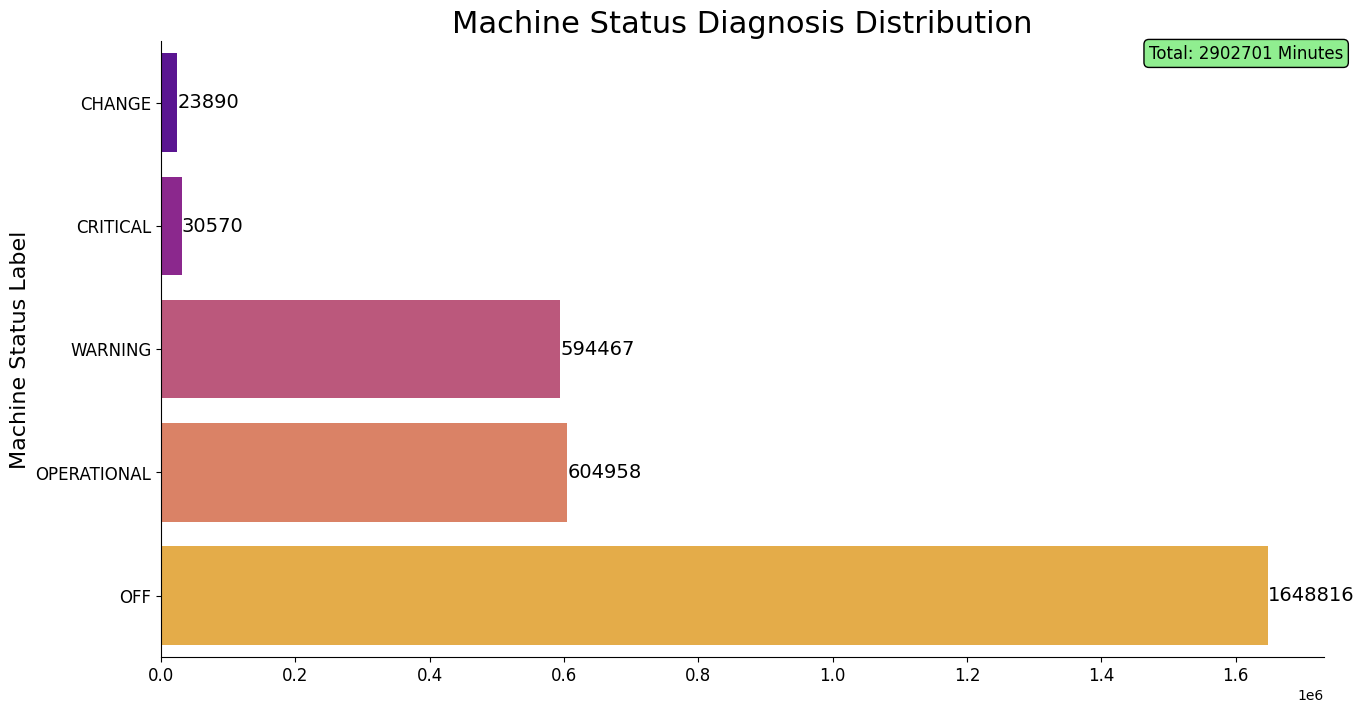

In [14]:
# View Diagnosis Distribution
fig = plt.figure(figsize=(15, 8))
plt.title('Machine Status Diagnosis Distribution', fontsize=22);

status_distribution = raw_data['status'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=status_distribution.values,
    y=status_distribution.index,
    hue=status_distribution.index,
    palette=sns.color_palette("plasma", n_colors=len(status_distribution)),
    orient="h",
    legend=False
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel('Machine Status Label', fontsize=16);

text_params = {
    'x'       : status_distribution.max() * 0.98,
    'y'       : -0.4,
    's'       : f"Total: {len(raw_data)} Minutes", 
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center", 
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params);
plt.grid(False);
sns.despine();

<div class="alert alert-block alert-info">
<br>
We observe that only 30,570 min. out of the 2,902,106 min. in the dataset have been assigned to 'CRITICAL' machine statut label. This drastically increases the difficulty of detecting when exactly the system experiences a breakdown as the labels in the dataset are severely imbalanced.
</div>

### Pump-level Summary

In [15]:
#Show counts alongside proportions
pump_counts = raw_data.groupby("pump")["status"].value_counts().unstack().fillna(0)
pump_summary = pump_counts.div(pump_counts.sum(axis=1), axis=0).round(3)
print("Pump-level (counts):\n", pump_counts)
print("\nPump-level (proportions):\n", pump_summary)

Pump-level (counts):
 status           CHANGE  CRITICAL       OFF  OPERATIONAL   WARNING
pump                                                              
Katosi_pump_A    1632.0       0.0  541919.0     419132.0     292.0
gunhill_pump_3  17751.0   17101.0  404329.0     140079.0  390603.0
muyenga_pump_4   4507.0   13469.0  702568.0      45747.0  203572.0

Pump-level (proportions):
 status          CHANGE  CRITICAL    OFF  OPERATIONAL  WARNING
pump                                                         
Katosi_pump_A    0.002     0.000  0.563        0.435    0.000
gunhill_pump_3   0.018     0.018  0.417        0.144    0.403
muyenga_pump_4   0.005     0.014  0.724        0.047    0.210


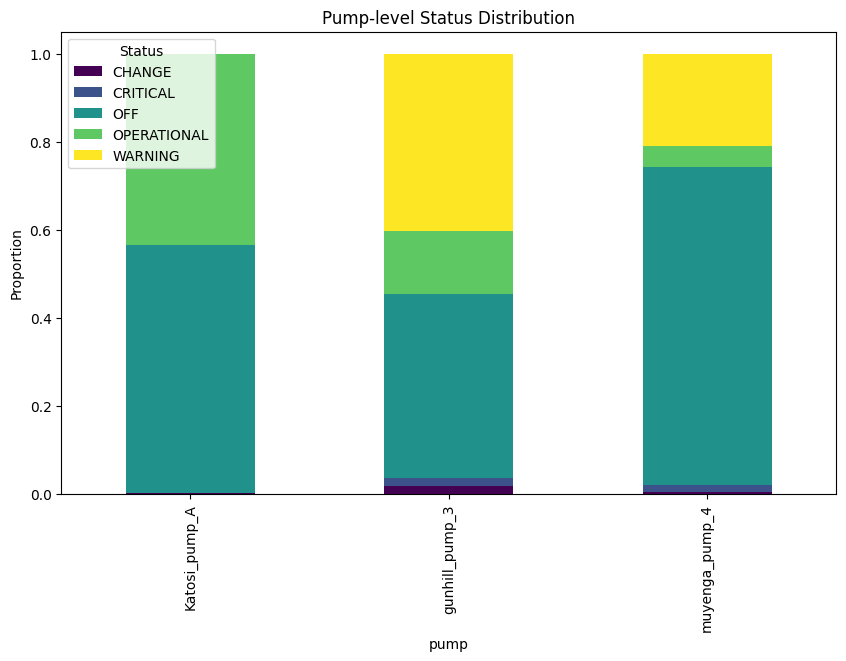

In [16]:
#Visualize with stacked bar chart
pump_summary.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Pump-level Status Distribution")
plt.ylabel("Proportion")
plt.legend(title="Status")
plt.show()


Pump utilization:

Katosi and Gunhill run more often than Muyenga (which is idle 72% of the time).

Reliability:

Gunhill and Muyenga show worrying high WARNING/CRITICAL rates compared to Katosi.

Maintenance priority:

Gunhill and Muyenga should be flagged for further inspection, especially Gunhill with 40% WARNING status.

<div class="alert alert-block alert-info">
<br>
We see that the dataset of Muyenga pump and Gunhill pump operate in critical mode most of the times while that of katosi has normal operations. We also observe some cases where sensor readings drop or spike drastically when these failures occur.
    
<p></p><p></p>
    
However, we observe that there is no clear pattern in the sensor readings which allow for clear system failure detections.
</div>

In [17]:
data_split = raw_data.copy()
# Generate encoding maps for labels 
label2id = {l: i for i,l in enumerate(statuses)} 
id2label = {v:k for k,v in label2id.items()} 
id2label 
# Generate encoded labels 
data_split['status_encoded'] = data_split['status'].map(label2id)

In [18]:
# Get the unique pump IDs/names 
pump_list = data_split['pump'].unique() 
# Create a dictionary with pump name as key and its respective DataFrame as value 
pump_data_dict = {pump: data_split[data_split['pump'] == pump].reset_index(drop=True) for pump in pump_list} 
# split to diffrent pumps 
katosi_pump = pump_data_dict['Katosi_pump_A'] 
muyenga_pump = pump_data_dict['muyenga_pump_4'] 
gunhill_pump = pump_data_dict['gunhill_pump_3']

In [19]:
def extract_status_window(df, time_column, status_column, target_status, window_size=300):
    """
    Extract a subset of the dataframe around rows where a specific status occurs.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing time, status, and sensor data.
    time_column : str
        Name of the timestamp column.
    status_column : str
        Column that contains status values.
    target_status : str or int
        The status value to extract windows around (e.g., "WARNING" or 4).
    window_size : int, optional
        Number of rows before and after each target event to include (default=300).

    Returns
    -------
    pd.DataFrame
        A subset dataframe containing rows within the specified windows.
    """
    # Ensure data is sorted by time
    df = df.copy()
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(time_column).reset_index(drop=True)
    
    # Get indices of target events
    target_indices = df.index[df[status_column] == target_status]
    
    # Collect all indices in window range
    all_indices = []
    for idx in target_indices:
        start = max(idx - window_size, 0)
        end = min(idx + window_size + 1, len(df))
        all_indices.extend(range(start, end))
    
    # Remove duplicates & sort
    all_indices = sorted(set(all_indices))
    
    # Return new dataframe subset
    return df.loc[all_indices].reset_index(drop=True)


In [20]:
katosi_critical_window_df = extract_status_window( katosi_pump, 
                                                  time_column="Time", 
                                                  status_column="status", 
                                                  target_status="WARNING", # could also be numeric if encoded 
                                                  window_size=500 ) 
muyenga_critical_window_df = extract_status_window( muyenga_pump, 
                                                   time_column="Time", 
                                                   status_column="status", 
                                                   target_status="CRITICAL", # could also be numeric if encoded 
                                                   window_size=5 ) 
gunhill_critical_window_df = extract_status_window( gunhill_pump, 
                                                   time_column="Time", 
                                                   status_column="status", 
                                                   target_status="CRITICAL", # could also be numeric if encoded 
                                                   window_size=500 ) 

In [21]:
def plot_sensor_groups(
    df, 
    sensors, 
    date_column, 
    id2label, 
    highlight_statuses=[0, 2, 3, 4],  # default: OPERATIONAL, CHANGE, WARNING, CRITICAL
    n_splits=10, 
    figsize=(20, 30), 
    start_date=None, 
    end_date=None
):
    """
    Plot sensor readings grouped into subplots with shaded status regions.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing sensor data and 'status_encoded'.
    sensors : list
        List of sensor column names.
    date_column : str
        Column name representing timestamps.
    id2label : dict
        Mapping of status codes to labels.
    highlight_statuses : list, optional
        Status codes to highlight (default: [0, 2, 3, 4]).
    n_splits : int, optional
        Number of groups to split sensors into (default: 10).
    figsize : tuple, optional
        Figure size (default: (20, 30)).
    start_date : str or pd.Timestamp, optional
        Start of time period to plot (default: None → no filter).
    end_date : str or pd.Timestamp, optional
        End of time period to plot (default: None → no filter).
    """
    # Copy and ensure datetime
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Apply time filtering if requested
    if start_date is not None:
        df = df[df[date_column] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df = df[df[date_column] <= pd.to_datetime(end_date)]
    
    # Default status colors
    status_colors = {
        0: "green",   # OPERATIONAL
        1: "orange",  # OFF
        2: "purple",  # CHANGE
        3: "yellow",  # WARNING
        4: "red"      # CRITICAL
    }
    status_colors = {k: v for k, v in status_colors.items() if k in highlight_statuses}
    
    # Split sensors into non-empty groups
    sensor_groups = [g for g in np.array_split(sensors, n_splits) if len(g) > 0]
    n_groups = len(sensor_groups)
    
    # Create figure
    fig, axes = plt.subplots(n_groups, 1, figsize=(figsize[0], 3*n_groups), sharex=True)
    fig.subplots_adjust(hspace=0.4)
    if n_groups == 1:
        axes = [axes]
    
    for group, (sensor_group, ax) in enumerate(zip(sensor_groups, axes)):
        query = df[[date_column, *sensor_group, 'status_encoded']]
        
        # Plot each sensor
        for sensor in sensor_group:
            sns.lineplot(data=query, x=date_column, y=sensor, label=sensor, errorbar=None, ax=ax)
        
        # Get min/max across the group for shading
        y_min = query[sensor_group].min().min()
        y_max = query[sensor_group].max().max()
        
        # Shade selected statuses
        for status_id, color in status_colors.items():
            ax.fill_between(
                query[date_column],
                y_min,
                y_max,
                where=query['status_encoded'] == status_id,
                color=color,
                alpha=0.2,
                interpolate=True,
                label=id2label.get(status_id, str(status_id))
            )
        
        ax.set_title(f'Group {group+1}: [{sensor_group[0]} - {sensor_group[-1]}]', fontsize=16)
        ax.set_ylabel('Sensor Readings', fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.4)
    
    # Global legend (deduplicated)
    handles, labels = axes[0].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(), loc='upper right', fontsize=12)
    
    sns.despine()
    plt.show()


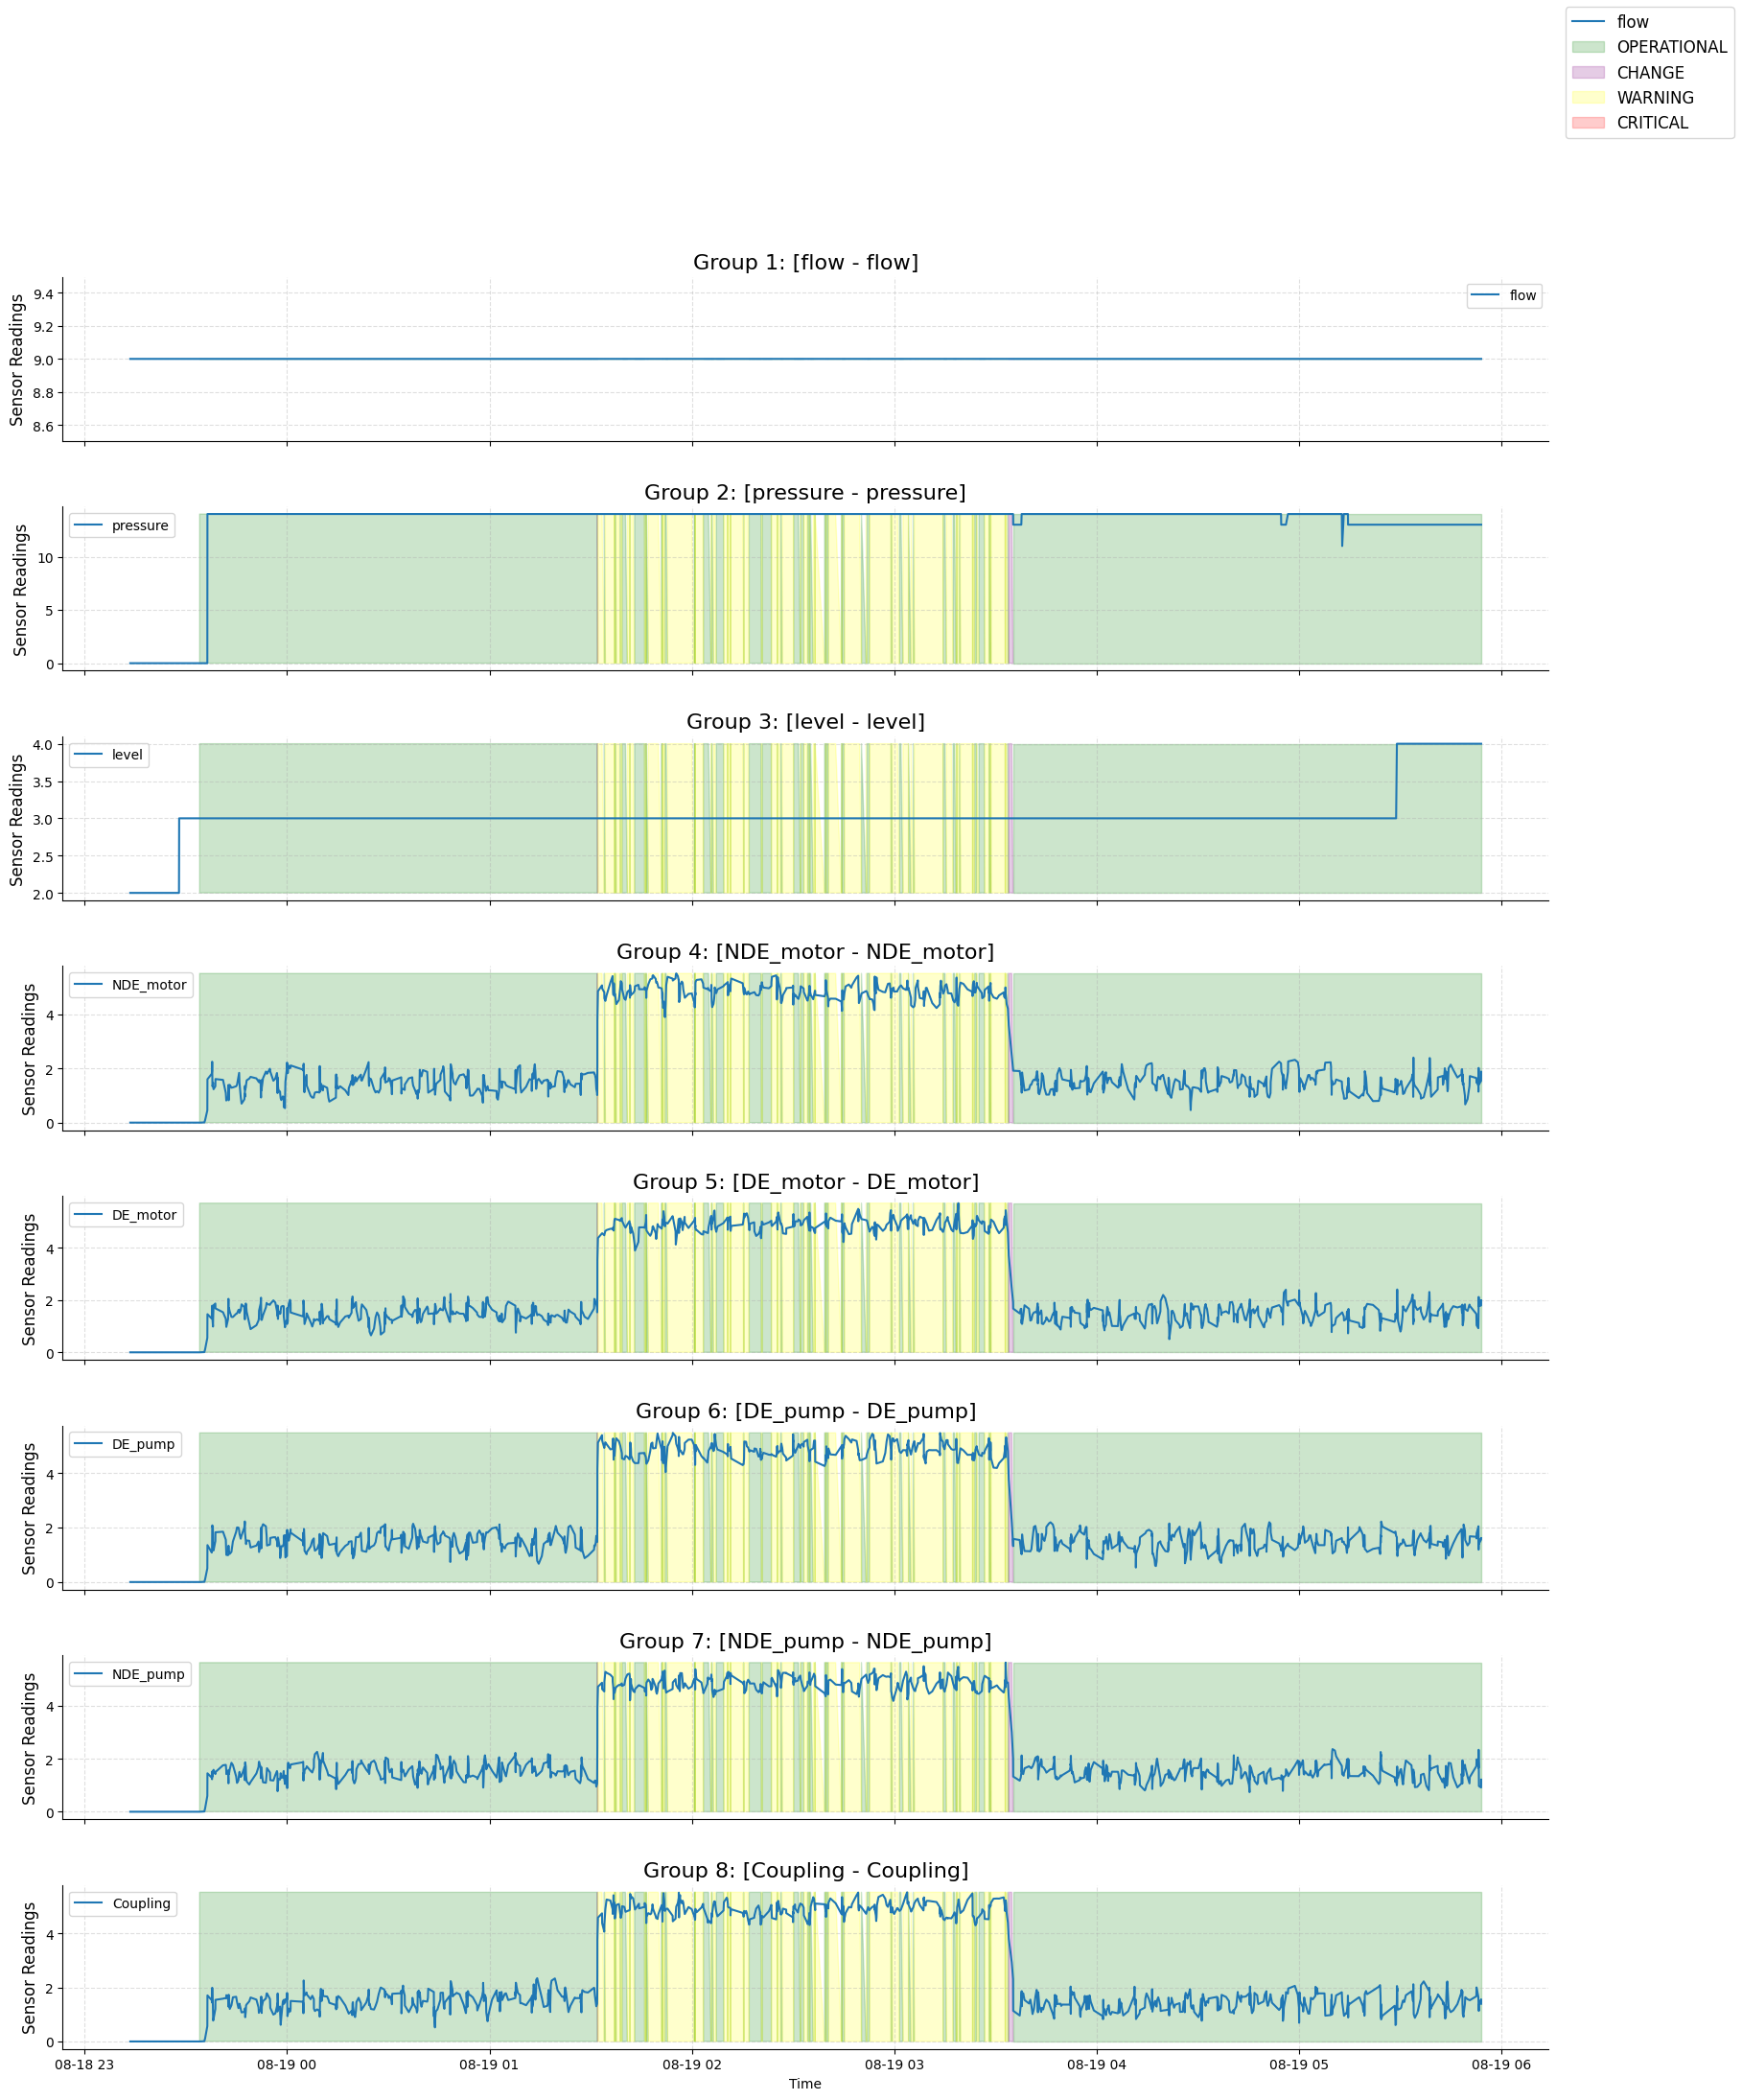

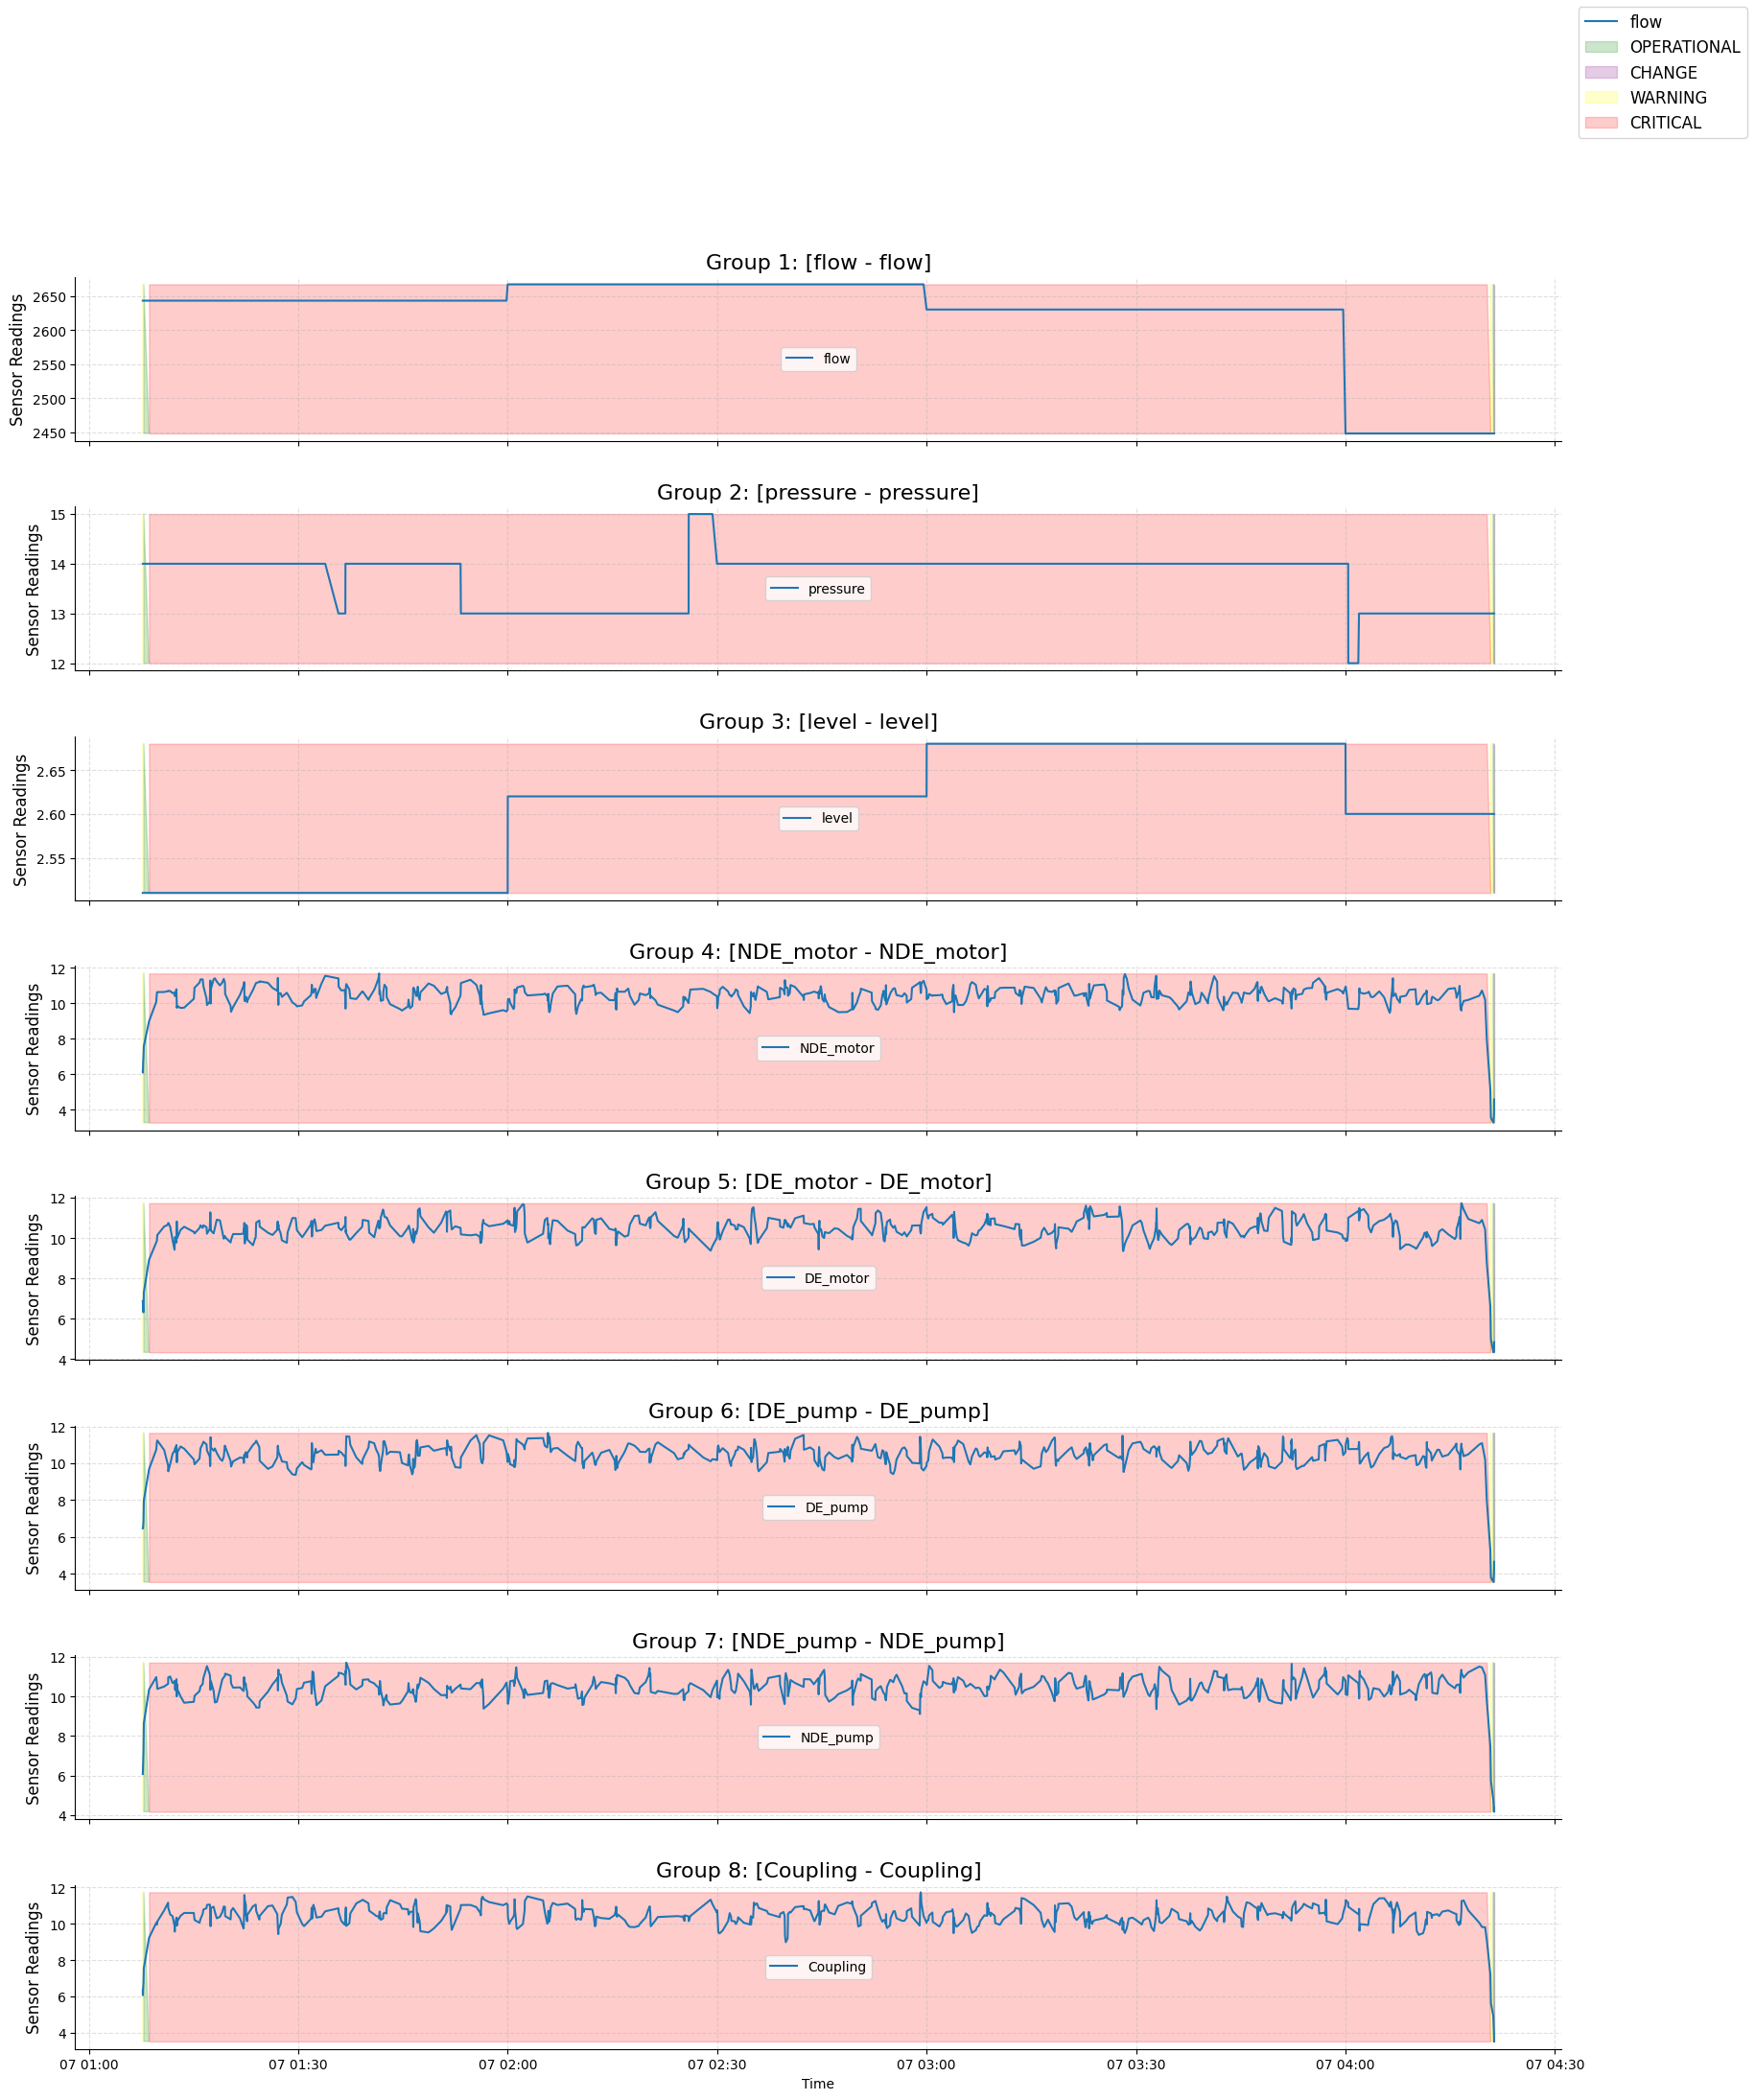

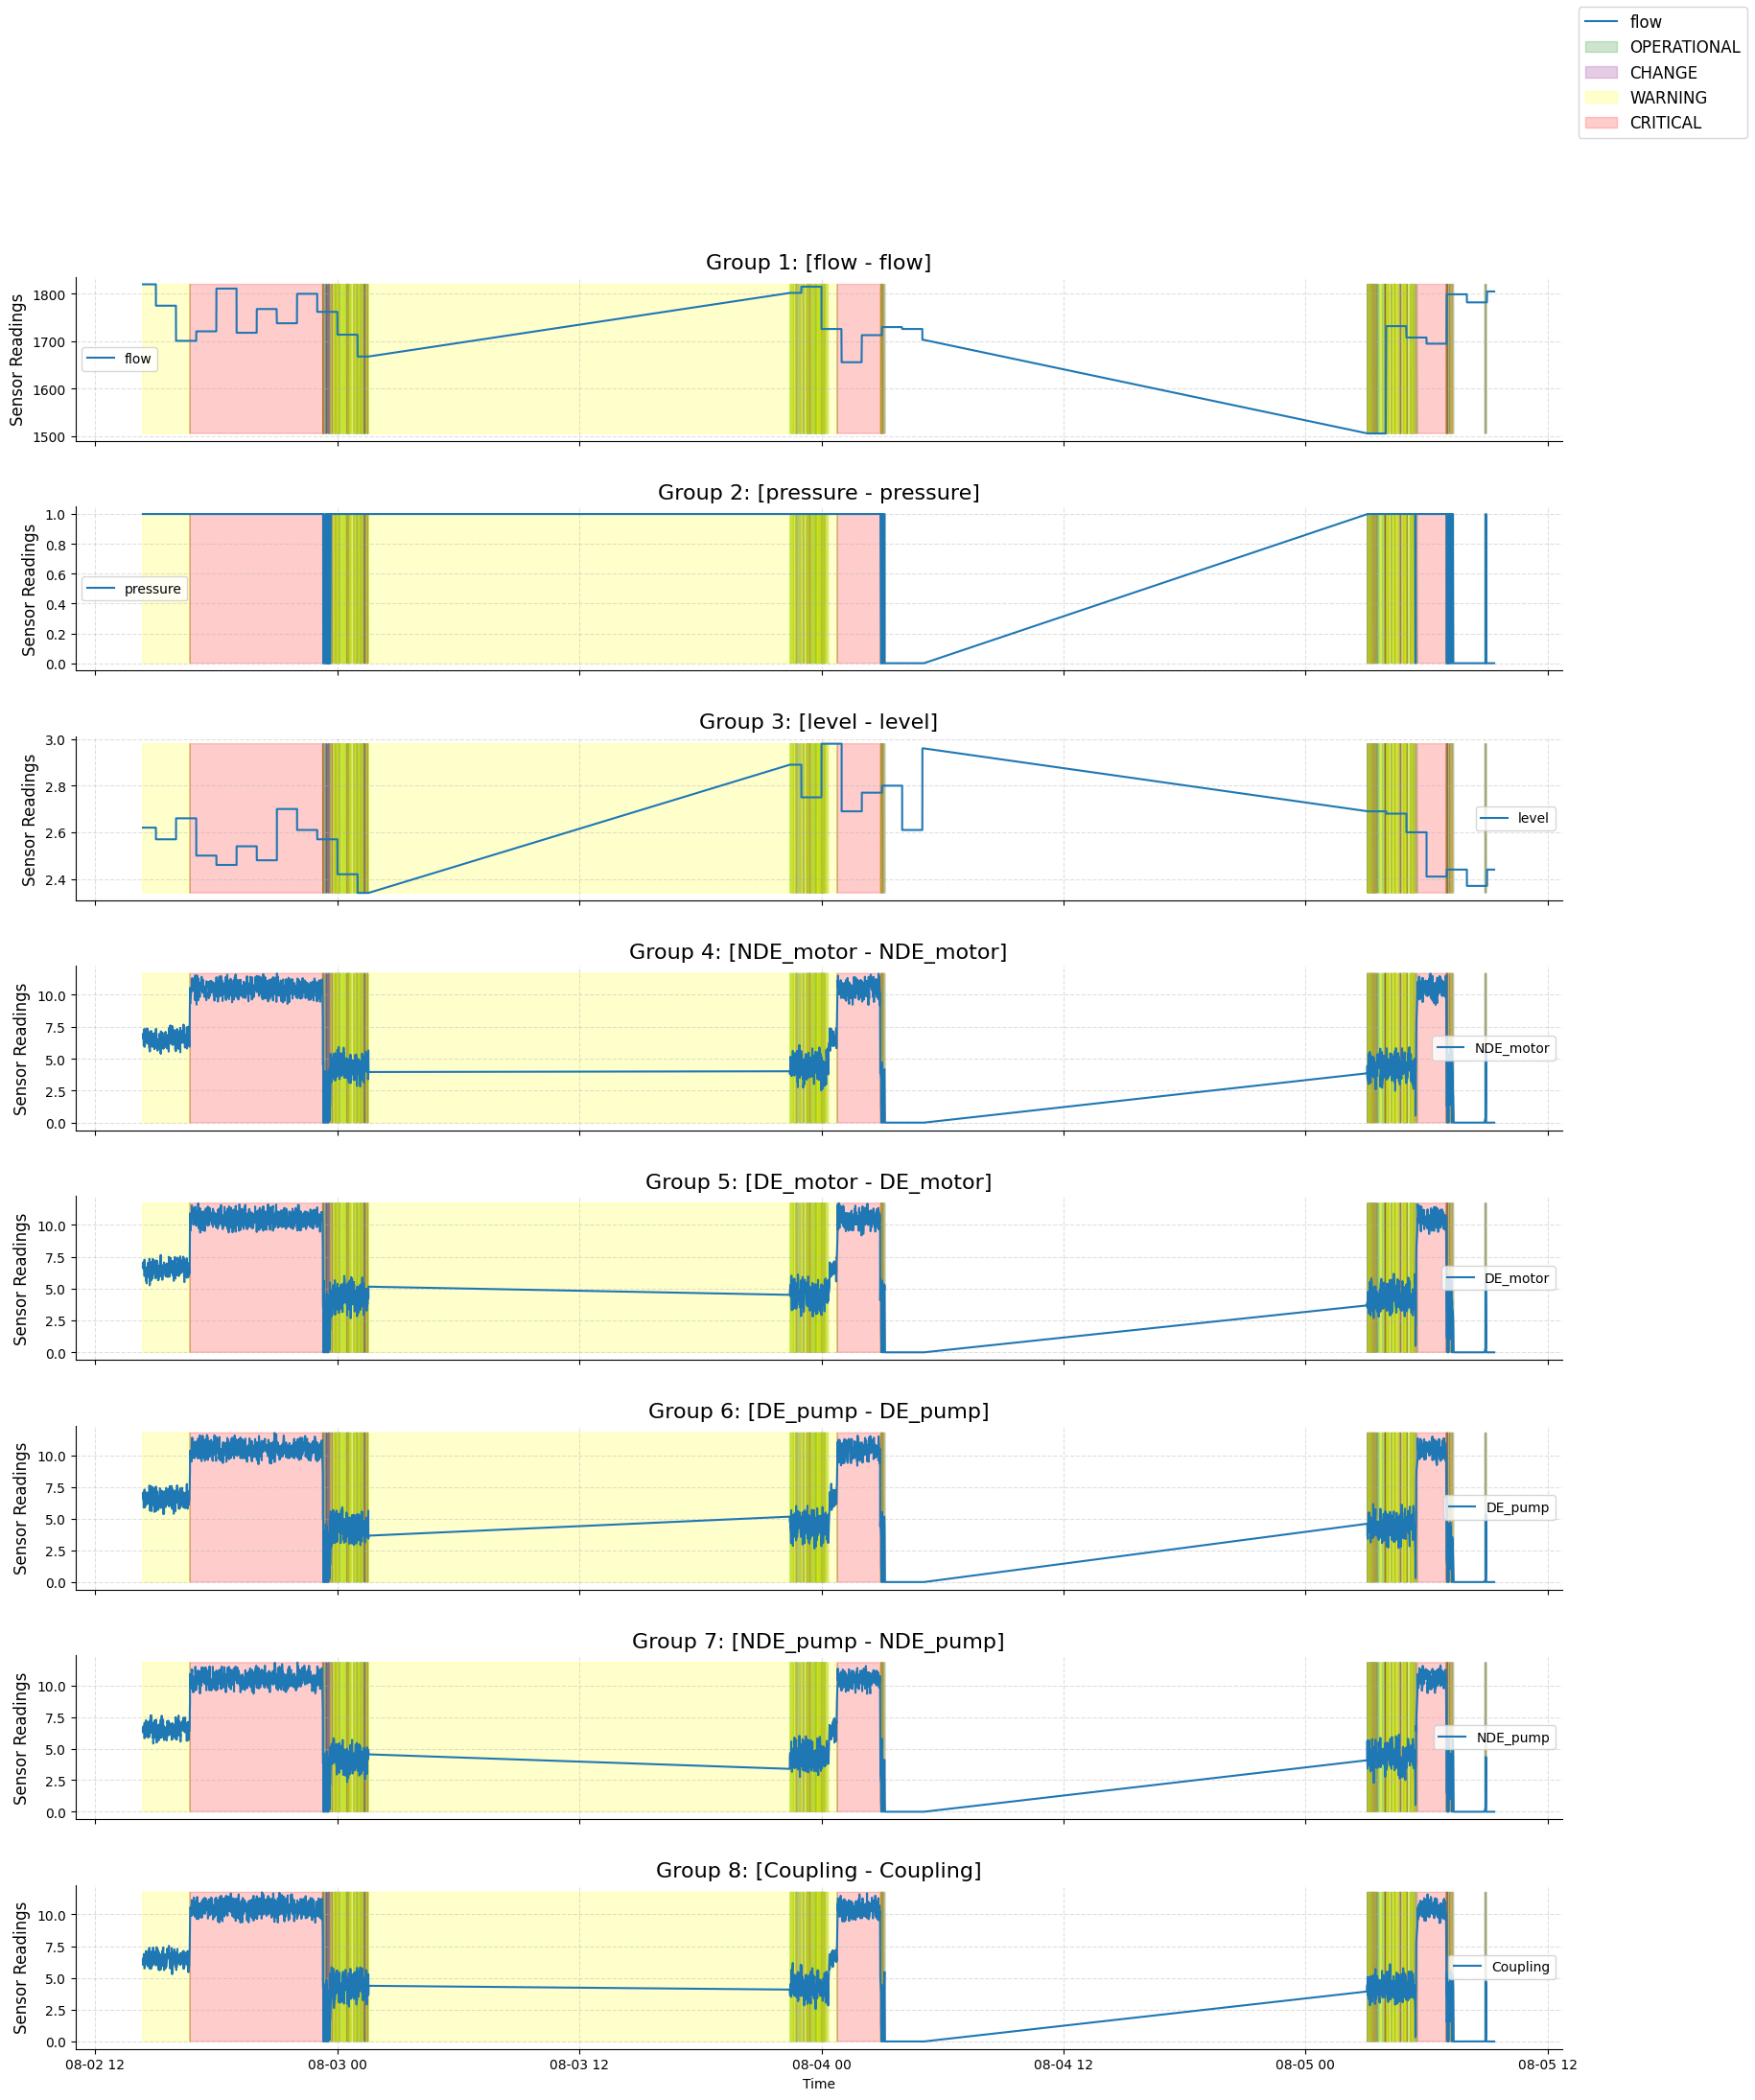

In [22]:
plot_sensor_groups( katosi_critical_window_df, sensors, date_column, id2label ) 
plot_sensor_groups( muyenga_critical_window_df, sensors, date_column, id2label, start_date="2024-11-03", end_date="2024-11-10" ) 
plot_sensor_groups( gunhill_critical_window_df, sensors, date_column, id2label, start_date="2024-08-01", end_date="2024-08-7" ) 


<div class="alert alert-block alert-info"> 
<br> We see that the dataset of Muyenga pump and Gunhill pump operate in critical mode most of the times while that of katosi has normal operations. 
We also observe some cases where sensor readings drop or spike drastically when these failures occur. 
<p></p><p></p> 
However, we observe that there is no clear pattern in the sensor readings which allow for clear system failure detections. </div>

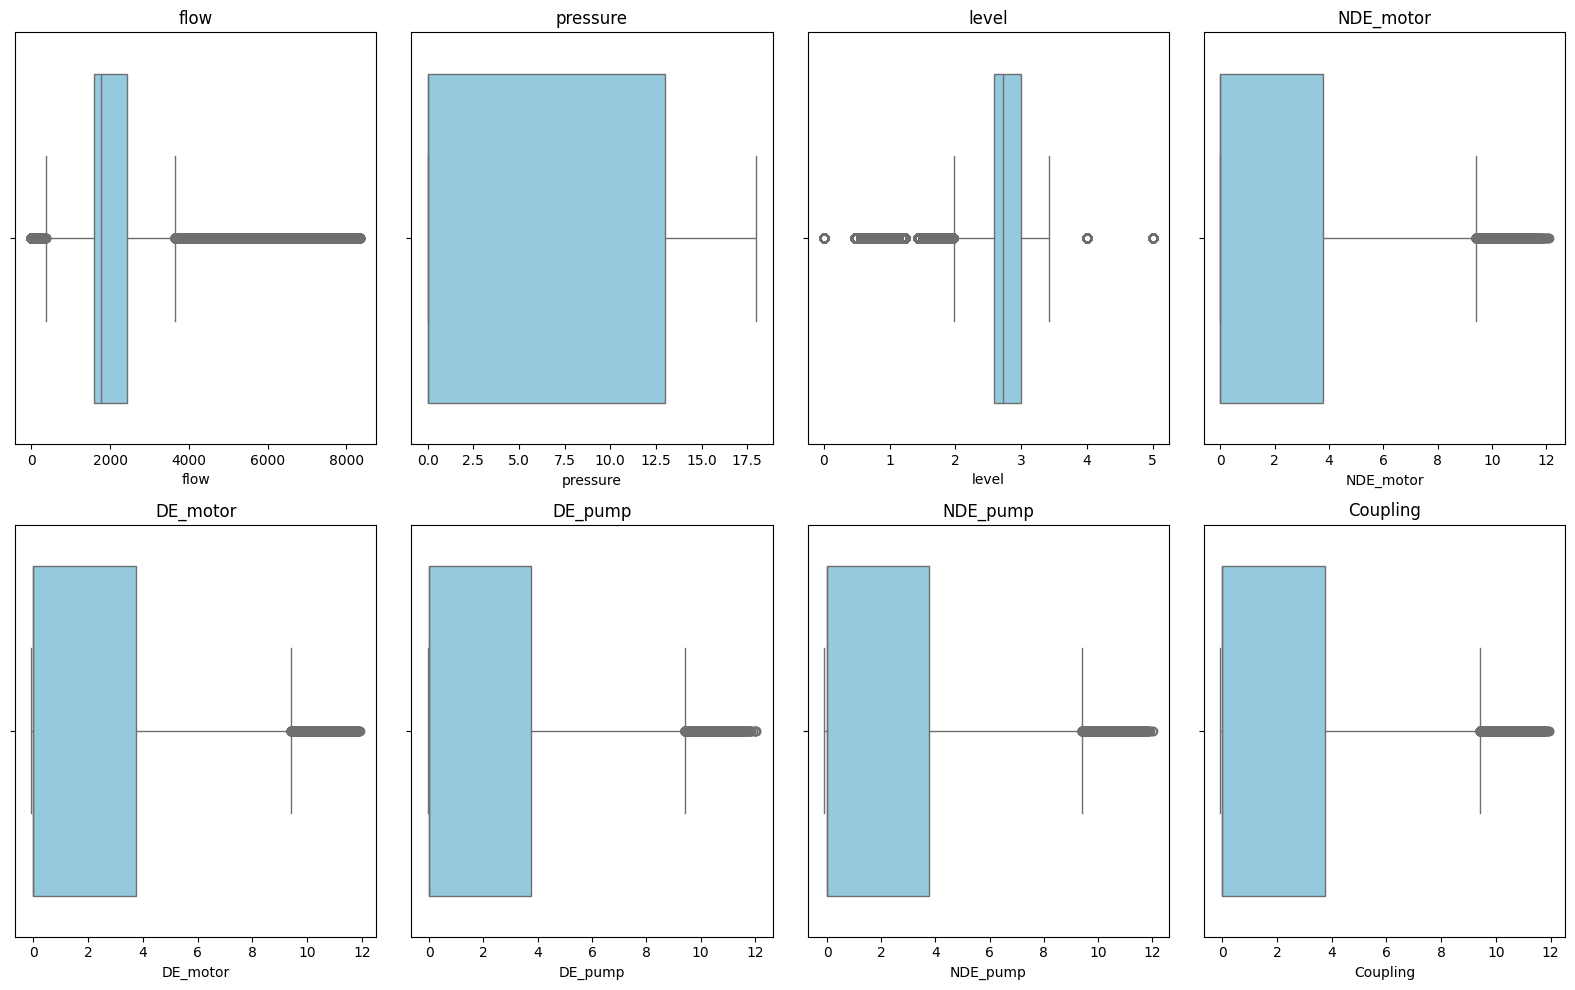

In [23]:
num_features = [c for c in sensors if raw_data[c].dtype != "object"]

fig, axs = plt.subplots(2, len(num_features)//2, figsize=(16,10))
axs = axs.flatten()
for i, feat in enumerate(num_features[:len(axs)]):
    sns.boxplot(x=raw_data[feat], ax=axs[i], color="skyblue")
    axs[i].set_title(feat)
plt.tight_layout()
plt.show()

Removing outliers blindly in predictive maintenance is risky because “weird” sensor readings may be the early warning patterns you want the model to detect

## 2.3) Outliers inspection <a id="outliers"></a>

The goal of this section is to check if the dataset contains any outlier, which are usually misleading
for machine learning algorithms. We begin by looking at a statistical report of the numerical
features.

In [24]:
# Create lists of features and target names
features = [col for col in raw_data.columns
            if raw_data[col].dtype=='float64' or col =='Type']
target = ['status']

In [25]:
# Quick numeric summary
raw_data.describe()

Time          flow      pressure         level     NDE_motor      DE_motor       DE_pump      NDE_pump      Coupling
count                        2902701  2.902701e+06  2.902701e+06  2.902701e+06  2.902701e+06  2.902701e+06  2.902701e+06  2.902701e+06  2.902701e+06
mean   2024-10-03 17:19:07.295728384  1.899094e+03  4.519487e+00  2.761639e+00  1.636077e+00  1.636119e+00  1.636263e+00  1.636994e+00  1.636071e+00
min              2024-07-01 00:00:00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -7.246815e-02 -5.323432e-02 -1.197250e-01 -6.927193e-02
25%              2024-08-18 19:13:40  1.604000e+03  0.000000e+00  2.590000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%              2024-10-05 01:48:31  1.778000e+03  0.000000e+00  2.720000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%              2024-11-18 14:16:33  2.422000e+03  1.300000e+01  3.000000e+00  3.765939e+00  3.762921e+00  3.761753e+00  3.764760e+00  3.761928e+00
max              2025-01-01 00:00:00  8.345000e+03  1.800000e+01  5.000000e+00  1.210199e+01  1.192333e+01  1.204626e+01  1.202587e+01  1.193710e+01
std                              NaN  1.504380e+03  6.309954e+00  5.482385e-01  2.282059e+00  2.282290e+00  2.282980e+00  2.283248e+00  2.282311e+00

## Resampling & Feature Engineering

In [26]:
raw_data1 = raw_data.copy()

In [27]:
# =====================================================
#  Step 1. Resample data to uniform 1-minute intervals
# =====================================================
df = raw_data1.set_index('Time')

# Define numeric sensor columns
numeric_cols = [
    'flow', 'pressure', 'level',
    'NDE_motor', 'DE_motor', 'DE_pump',
    'NDE_pump', 'Coupling'
]

# Resample (mean, std, min, max) + keep latest status & pump ID
resampled_df = df.resample('1min').agg(
    {col: ['mean', 'std', 'min', 'max'] for col in numeric_cols} |
    {'status': 'last', 'pump': 'last'}
)

# Flatten MultiIndex columns: flow_mean, flow_std, ...
resampled_df.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in resampled_df.columns
]


### Define prediction horizons

In [28]:
# =====================================================
#   Step 2. Define prediction horizons
# =====================================================
horizons = {
    "1h": 60,
    "6h": 6 * 60,
    "1d": 24 * 60,
    "3d": 3 * 24 * 60,
    "5d": 5 * 24 * 60
}

# Shift labels for multi-horizon prediction
for name, steps in horizons.items():
    resampled_df[f"status_future_{name}"] = resampled_df['status_last'].shift(-steps)

# Drop rows where furthest horizon is NaN
resampled_df = resampled_df.dropna(subset=[f"status_future_{h}" for h in horizons])


### Outlier Handling (IQR clipping instead of removal)

In [29]:
# =====================================================
#  Step 3. Outlier Handling (IQR clipping instead of removal)
# =====================================================
def remove_outliers_iqr(series, factor=1.5):
    """Clip extreme values instead of dropping rows."""
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - factor*IQR, Q3 + factor*IQR
    return series.clip(lower, upper)

for col in resampled_df.columns:
    if any(sensor in col for sensor in numeric_cols):
        resampled_df[col] = remove_outliers_iqr(resampled_df[col])


Rolling Statistics (time-domain)

detects rising vibration, falling flow, fluctuating pressure → early warnings.

In [30]:
# =====================================================
#  Step 4. Rolling statistics
# =====================================================
windows = [3, 5, 10]  # in minutes

for col in [c for c in resampled_df.columns if any(sensor in c for sensor in numeric_cols)]:
    for w in windows:
        resampled_df[f"{col}_roll_mean_{w}"] = resampled_df[col].rolling(w, min_periods=1).mean()
        resampled_df[f"{col}_roll_std_{w}"]  = resampled_df[col].rolling(w, min_periods=1).std()
        resampled_df[f"{col}_roll_min_{w}"]  = resampled_df[col].rolling(w, min_periods=1).min()
        resampled_df[f"{col}_roll_max_{w}"]  = resampled_df[col].rolling(w, min_periods=1).max()


### Trend Features (slopes, deltas)

In [31]:
new_features = []  # list of DataFrames

for col in [c for c in resampled_df.columns if any(sensor in c for sensor in numeric_cols)]:
    tmp = pd.DataFrame(index=resampled_df.index)
    tmp[f"{col}_delta"] = resampled_df[col].diff()
    tmp[f"{col}_slope"] = resampled_df[col].diff().rolling(5, min_periods=1).mean()
    new_features.append(tmp)

# Concatenate all new features at once
delta_slope_features = pd.concat(new_features, axis=1)

# Merge with original
resampled_df = pd.concat([resampled_df, delta_slope_features], axis=1)


resampled_df = resampled_df.copy()


Frequency-Domain Features (for vibration only)

bearing wear, imbalance, misalignment → show up as new peaks in frequency domain.

In [32]:
# =====================================================
#  Step 6. FFT Features (frequency-domain for vibration signals)
# =====================================================
from scipy.fft import rfft, rfftfreq

def compute_fft(series, fs=1/60):  # fs = 1 sample per minute
    series = series.dropna()
    N = len(series)
    if N < 10:  # too few samples
        return np.nan
    yf = np.abs(rfft(series))
    xf = rfftfreq(N, fs)
    return xf[np.argmax(yf)]  # dominant frequency

vib_cols = ['NDE_motor', 'DE_motor', 'DE_pump', 'NDE_pump', 'Coupling']

for col in vib_cols:
    resampled_df[f"{col}_fft_freq"] = resampled_df[col+"_mean"].rolling(window=60, min_periods=30).apply(compute_fft, raw=False)


In [33]:
# =====================================================
#  Step 7. Lag features (temporal dependency)
# =====================================================
# lags = [1, 2, 3, 5, 10]  # minutes back

# for col in [c for c in resampled_df.columns if any(sensor in c for sensor in numeric_cols)]:
#     for lag in lags:
#         resampled_df[f"{col}_lag_{lag}"] = resampled_df[col].shift(lag)


In [34]:
# =====================================================
#  Step 8. Final cleanup
# =====================================================
# Fill any remaining NaNs (caused by rolling/lag)
resampled_df = resampled_df.fillna(method="bfill").fillna(method="ffill")

print("Final feature count:", resampled_df.shape[1])
resampled_df.head()


Final feature count: 1260


flow_mean     flow_std  flow_min  flow_max  pressure_mean  pressure_std  pressure_min  pressure_max  level_mean  level_std  \
Time                                                                                                                                                
2024-07-01 00:00:00  1322.666667   967.019386       7.0    2195.0       4.666667      6.741608           0.0          14.0    3.157500   0.612154   
2024-07-01 00:01:00  1322.666667  1037.012761       7.0    2195.0       4.666667      7.229569           0.0          14.0    3.153333   0.655825   
2024-07-01 00:07:00  1322.666667   964.692019       7.0    2195.0       4.666667      6.725382           0.0          14.0    3.153333   0.610088   
2024-07-01 00:09:00  1322.666667   964.692019       7.0    2195.0       4.666667      6.725382           0.0          14.0    3.153333   0.610088   
2024-07-01 00:18:00  1322.666667   964.692019       7.0    2195.0       4.666667      6.725382           0.0          14.0    3.153333   0.610088   

                     level_min  level_max  NDE_motor_mean  NDE_motor_std  NDE_motor_min  NDE_motor_max  DE_motor_mean  DE_motor_std  DE_motor_min  \
Time                                                                                                                                                
2024-07-01 00:00:00       2.56        4.0        0.784149       0.848749            0.0       2.599319       0.597716      0.645619           0.0   
2024-07-01 00:01:00       2.73        4.0        0.486961       0.756912            0.0       1.558371       0.381692      0.593953           0.0   
2024-07-01 00:07:00       2.73        4.0        0.425688       0.650159            0.0       1.962767       0.482422      0.742886           0.0   
2024-07-01 00:09:00       2.73        4.0        0.425688       0.650159            0.0       1.962767       0.482422      0.742886           0.0   
2024-07-01 00:18:00       2.73        4.0        0.425688       0.650159            0.0       1.962767       0.482422      0.742886           0.0   

                     DE_motor_max  DE_pump_mean  DE_pump_std  DE_pump_min  DE_pump_max  NDE_pump_mean  NDE_pump_std  NDE_pump_min  NDE_pump_max  \
Time                                                                                                                                              
2024-07-01 00:00:00      1.779842      0.924726     1.147488          0.0     4.052993       0.916074      1.281126           0.0      4.539873   
2024-07-01 00:01:00      1.233503      0.511753     0.797683          0.0     1.674525       0.371200      0.595714           0.0      1.359467   
2024-07-01 00:07:00      2.070315      0.381692     0.650987          0.0     1.960066       0.395983      0.575655           0.0      1.397720   
2024-07-01 00:09:00      2.070315      0.381692     0.650987          0.0     1.960066       0.395983      0.575655           0.0      1.397720   
2024-07-01 00:18:00      2.070315      0.381692     0.650987          0.0     1.960066       0.395983      0.575655           0.0      1.397720   

                     Coupling_mean  Coupling_std  Coupling_min  Coupling_max status_last       pump_last status_future_1h status_future_6h  \
Time                                                                                                                                         
2024-07-01 00:00:00       0.914176      1.120127           0.0      3.891900         OFF  gunhill_pump_3              OFF              OFF   
2024-07-01 00:01:00       0.438593      0.679803           0.0      1.349667         OFF  gunhill_pump_3              OFF              OFF   
2024-07-01 00:07:00       0.403738      0.612068           0.0      1.709952         OFF  gunhill_pump_3              OFF              OFF   
2024-07-01 00:09:00       0.403738      0.612068           0.0      1.709952         OFF  gunhill_pump_3              OFF              OFF   
2024-07-01 00:18:00       0.403738      0.612068     

## Feature Selection & Modeling Setup

In [35]:
resampled = resampled_df.copy()

In [36]:
# ================================================================
# Feature Preparation
# ================================================================
X = resampled.drop(['status_last', 'pump_last'] + [f'status_future_{h}' for h in horizons], axis=1)
y = resampled['status_future_1d']

In [37]:
# Encode categorical labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [38]:
# ---- 1. Remove low-variance features ----
selector_var = VarianceThreshold(threshold=1e-4)
X_reduced = selector_var.fit_transform(X)
cols_kept = X.columns[selector_var.get_support()]
X_reduced = pd.DataFrame(X_reduced, columns=cols_kept, index=X.index)

In [39]:
# ---- 2. SelectKBest ----
selector_k = SelectKBest(score_func=f_classif, k=50)
X_selected = selector_k.fit_transform(X_reduced, y_encoded)
selected_cols = X_reduced.columns[selector_k.get_support()]
X_selected = pd.DataFrame(X_selected, columns=selected_cols, index=X.index)

In [40]:
# ---- 3. Tree-based importance (XGBoost) ----
xgb_model = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_model.fit(X_selected, y_encoded)

importances = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

top_features = importances.head(30)['feature'].tolist()
X_final = X_selected[top_features]

print("Final feature set shape:", X_final.shape)
print("Top features:", top_features)

Final feature set shape: (125171, 30)
Top features: ['DE_pump_max_roll_max_10', 'DE_motor_mean_roll_max_5', 'DE_motor_mean_roll_max_10', 'NDE_motor_max_roll_max_10', 'DE_pump_mean_roll_max_5', 'NDE_pump_mean_roll_mean_10', 'DE_motor_max_roll_max_10', 'NDE_pump_mean_roll_max_10', 'Coupling_mean_roll_max_10', 'Coupling_max_roll_max_10', 'Coupling_mean_roll_max_3', 'NDE_pump_max_roll_max_10', 'DE_pump_mean_roll_max_10', 'NDE_motor_mean_roll_mean_10', 'NDE_motor_mean_roll_max_10', 'NDE_pump_mean_roll_max_5', 'Coupling_mean_roll_mean_10', 'DE_pump_mean_roll_mean_10', 'DE_motor_mean_roll_mean_10', 'NDE_motor_mean_roll_min_5', 'Coupling_mean_roll_max_5', 'NDE_pump_mean_roll_max_3', 'NDE_pump_mean_roll_min_5', 'DE_pump_mean_roll_min_5', 'NDE_motor_mean_roll_max_3', 'Coupling_mean_roll_mean_5', 'DE_pump_mean_roll_max_3', 'DE_motor_mean_roll_mean_5', 'NDE_motor_mean_roll_max_5', 'DE_motor_mean_roll_min_3']


In [41]:
# ================================================================
# Models
# ================================================================
models = {
    'XGB': XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, 
        scale_pos_weight=1  # tune if imbalance severe
    ),
    'LGB': LGBMClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, n_jobs=-1, class_weight='balanced'
    ),
    'RF': RandomForestClassifier(
        n_estimators=200, max_depth=10,
        random_state=42, n_jobs=-1, class_weight='balanced'
    ),
    'Cat': CatBoostClassifier(
        iterations=200, depth=6, learning_rate=0.1,
        verbose=0, random_state=42, auto_class_weights="Balanced"
    )
}

# Voting ensemble
voting = VotingClassifier(
    estimators=[('xgb', models['XGB']), ('lgb', models['LGB']),
                ('rf', models['RF']), ('cat', models['Cat'])],
    voting='soft', n_jobs=-1
)
models['Voting'] = voting

In [42]:
# ================================================================
# Time-based split
# ================================================================
def time_based_split(X, y, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    X_train = X.iloc[:train_end]; y_train = y.iloc[:train_end]
    X_val = X.iloc[train_end:val_end]; y_val = y.iloc[train_end:val_end]
    X_test = X.iloc[val_end:]; y_test = y.iloc[val_end:]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [43]:
# Initialize results

all_metrics = []

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    # labels should be the actual status names
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=labels, cmap=plt.cm.Blues, normalize=None
    )
    plt.title(title)
    plt.show()

def plot_roc_pr_curves(y_test, y_proba, label_names, title="ROC & PR Curves"):
    n_classes = len(label_names)
    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    
    # ROC Curve
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'ROC Curve - {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()

    # PR Curve
    plt.subplot(1,2,2)
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{label_names[i]} (AUC={pr_auc:.2f})')
    plt.title(f'Precision-Recall Curve - {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()

    plt.show()


=== Horizon: 1h ===

XGB | Acc: 0.7375 | Prec: 0.7078 | Rec: 0.7375 | F1: 0.7101 | AUC: 0.8029955470120702
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        73
    CRITICAL     0.1149    0.0877    0.0995       114
         OFF     0.7923    0.8287    0.8101      9737
 OPERATIONAL     0.3333    0.0016    0.0031      1288
     WARNING     0.6784    0.7623    0.7179      7564

    accuracy                         0.7375     18776
   macro avg     0.3838    0.3361    0.3261     18776
weighted avg     0.7078    0.7375    0.7101     18776



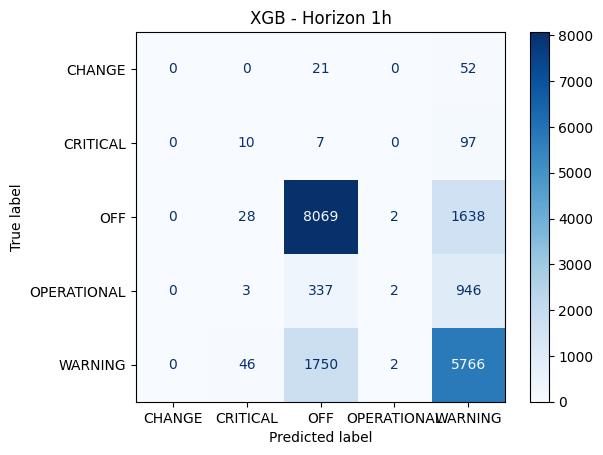

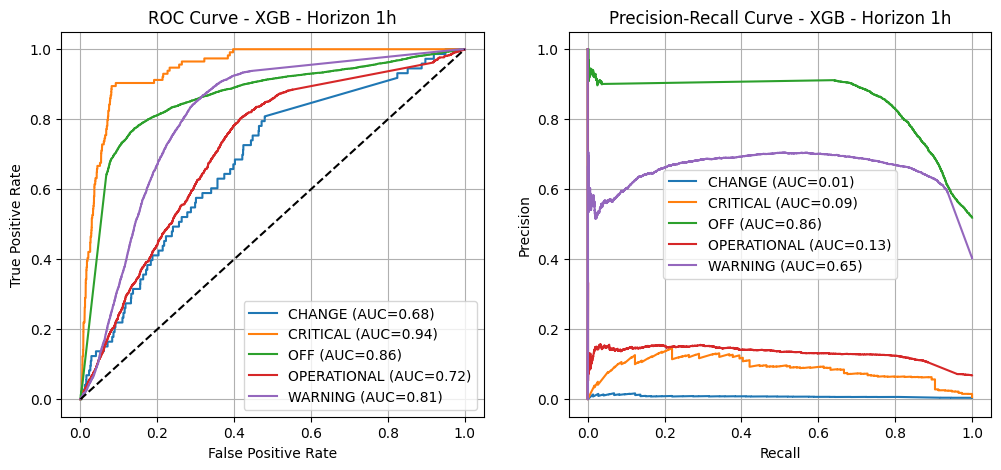

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 87619, number of used features: 30
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

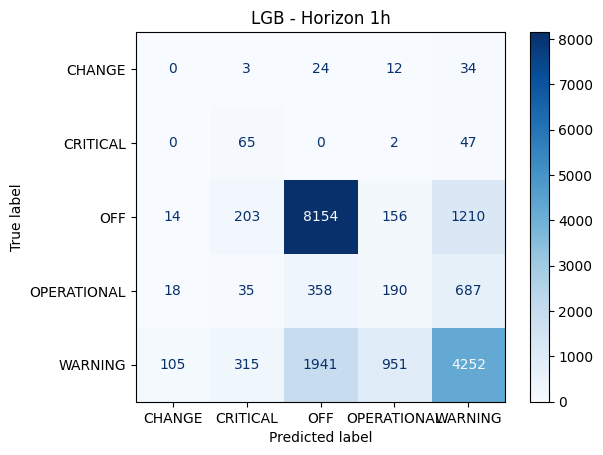

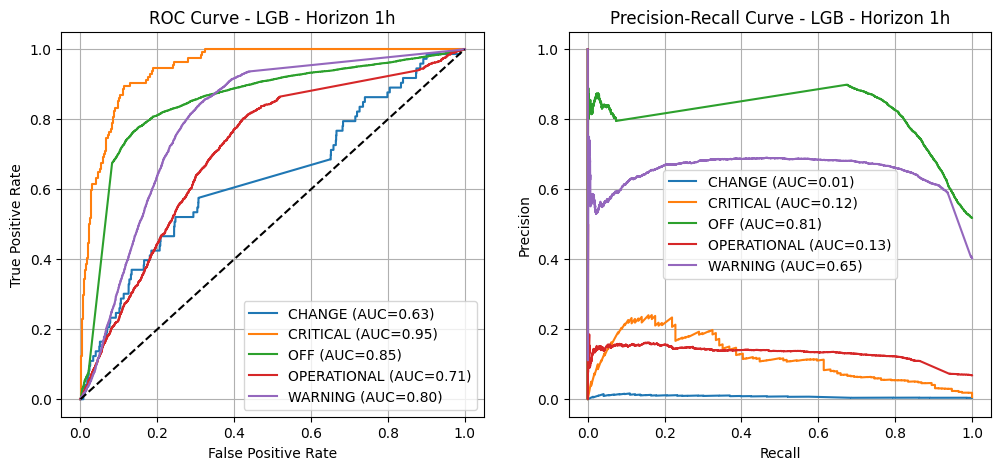


RF | Acc: 0.6544 | Prec: 0.7131 | Rec: 0.6544 | F1: 0.6793 | AUC: 0.7976794972646977
              precision    recall  f1-score   support

      CHANGE     0.0225    0.0274    0.0247        73
    CRITICAL     0.0760    0.7544    0.1380       114
         OFF     0.8421    0.7880    0.8142      9737
 OPERATIONAL     0.1421    0.2236    0.1738      1288
     WARNING     0.6605    0.5603    0.6063      7564

    accuracy                         0.6544     18776
   macro avg     0.3486    0.4707    0.3514     18776
weighted avg     0.7131    0.6544    0.6793     18776



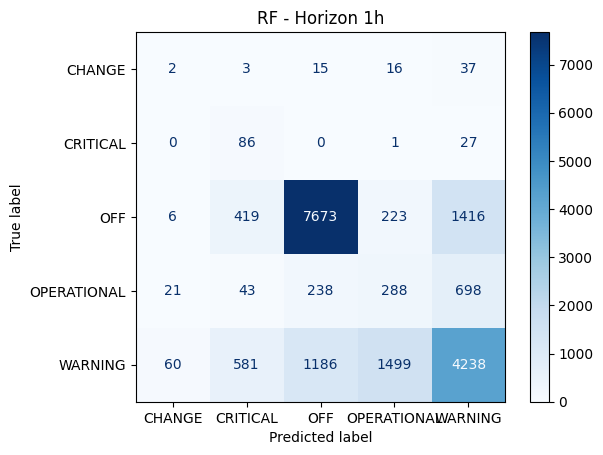

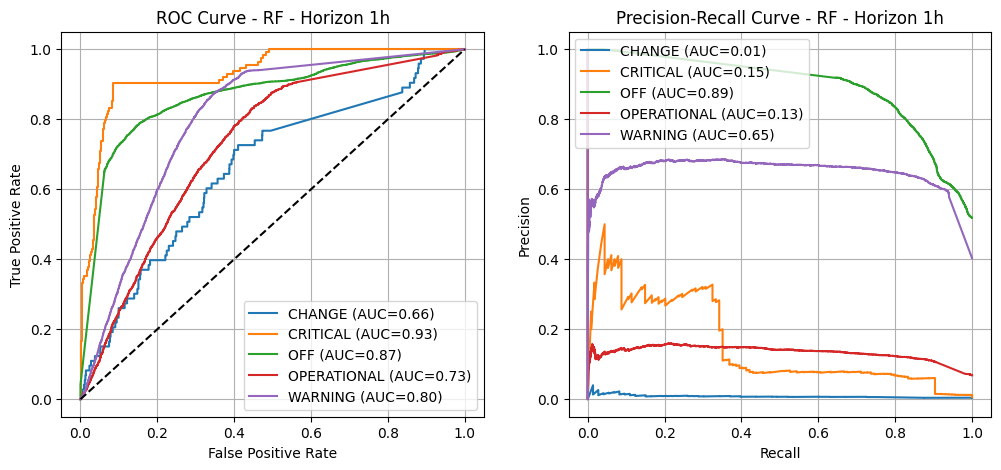


Cat | Acc: 0.6655 | Prec: 0.7089 | Rec: 0.6655 | F1: 0.6792 | AUC: 0.8030279373569977
              precision    recall  f1-score   support

      CHANGE     0.0126    0.0411    0.0193        73
    CRITICAL     0.0588    0.8772    0.1101       114
         OFF     0.7896    0.8397    0.8139      9737
 OPERATIONAL     0.1410    0.0831    0.1045      1288
     WARNING     0.7182    0.5434    0.6186      7564

    accuracy                         0.6655     18776
   macro avg     0.3440    0.4769    0.3333     18776
weighted avg     0.7089    0.6655    0.6792     18776



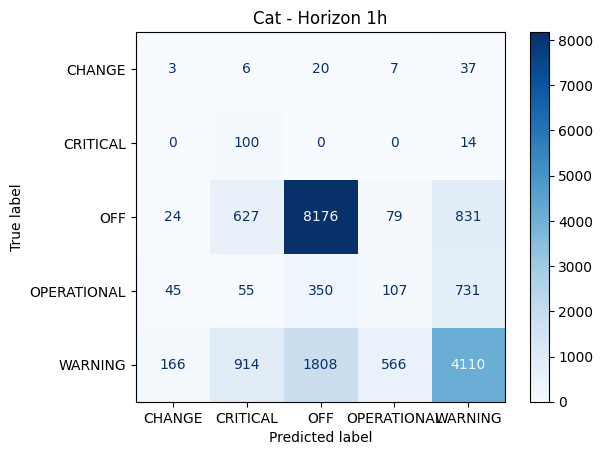

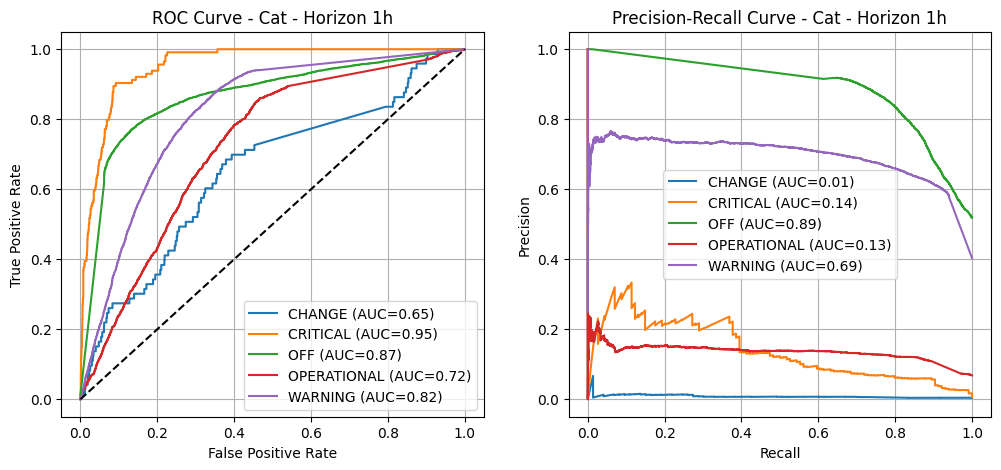


Voting | Acc: 0.7251 | Prec: 0.6991 | Rec: 0.7251 | F1: 0.7080 | AUC: 0.8066684402712994
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        73
    CRITICAL     0.1002    0.5702    0.1704       114
         OFF     0.7951    0.8323    0.8133      9737
 OPERATIONAL     0.1000    0.0070    0.0131      1288
     WARNING     0.6933    0.7187    0.7057      7564

    accuracy                         0.7251     18776
   macro avg     0.3377    0.4256    0.3405     18776
weighted avg     0.6991    0.7251    0.7080     18776



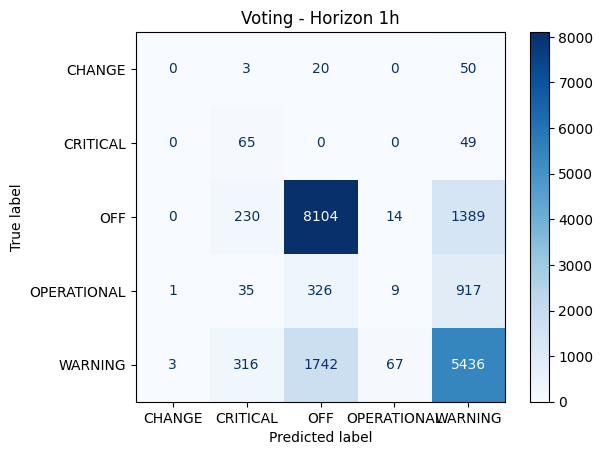

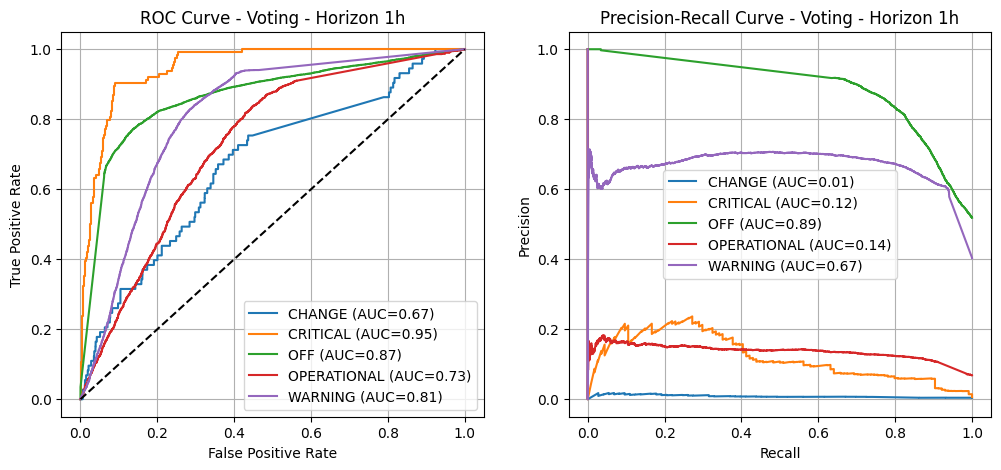


=== Horizon: 6h ===

XGB | Acc: 0.5514 | Prec: 0.5206 | Rec: 0.5514 | F1: 0.5322 | AUC: 0.6057312463377954
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        62
    CRITICAL     0.0000    0.0000    0.0000       113
         OFF     0.6124    0.6315    0.6218      9950
 OPERATIONAL     0.0909    0.0008    0.0016      1219
     WARNING     0.4804    0.5476    0.5118      7432

    accuracy                         0.5514     18776
   macro avg     0.2368    0.2360    0.2270     18776
weighted avg     0.5206    0.5514    0.5322     18776



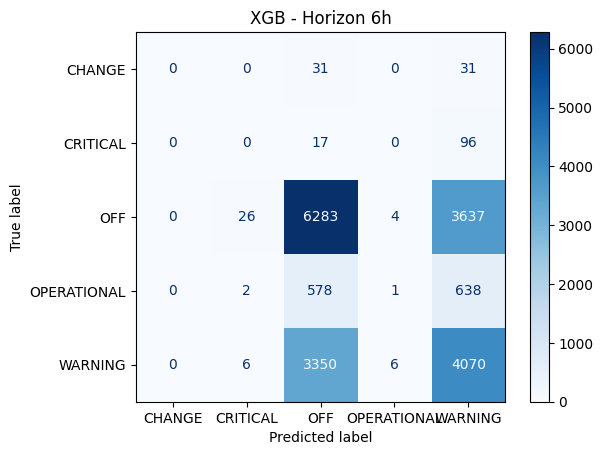

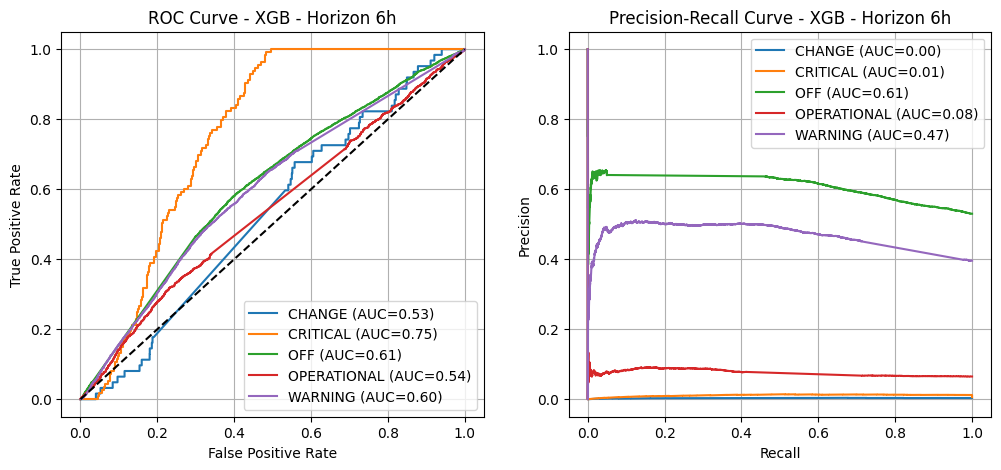

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 87619, number of used features: 30
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

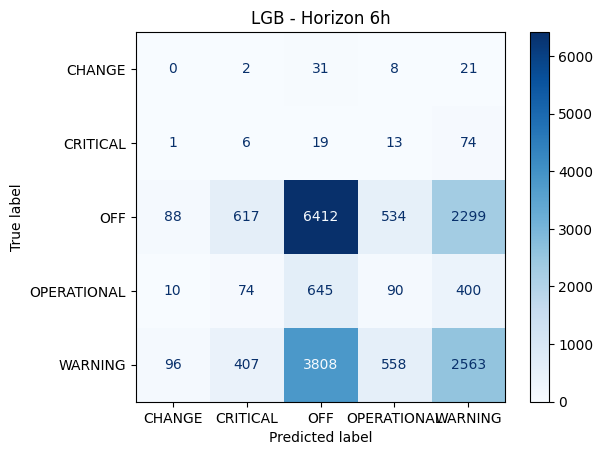

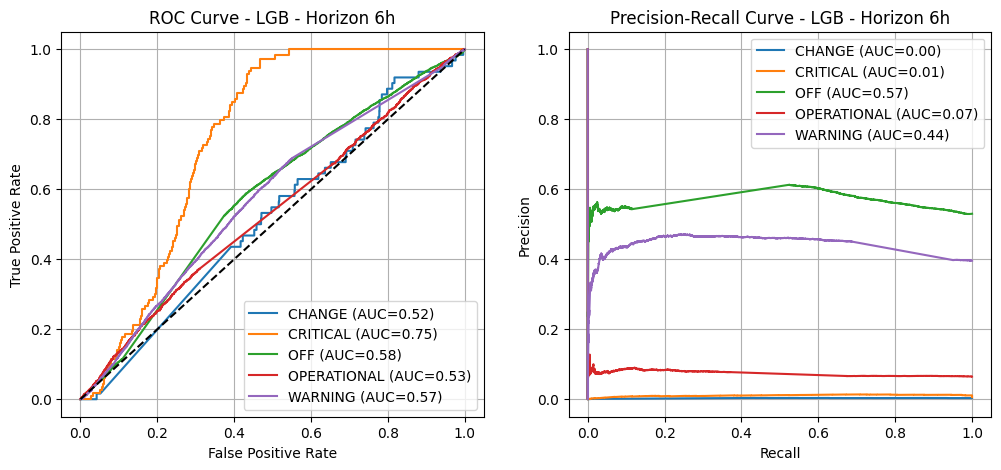


RF | Acc: 0.3922 | Prec: 0.5355 | Rec: 0.3922 | F1: 0.4416 | AUC: 0.6119915890224539
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        62
    CRITICAL     0.0155    0.7345    0.0303       113
         OFF     0.6538    0.5611    0.6039      9950
 OPERATIONAL     0.0726    0.0820    0.0770      1219
     WARNING     0.4653    0.2150    0.2941      7432

    accuracy                         0.3922     18776
   macro avg     0.2414    0.3185    0.2011     18776
weighted avg     0.5355    0.3922    0.4416     18776



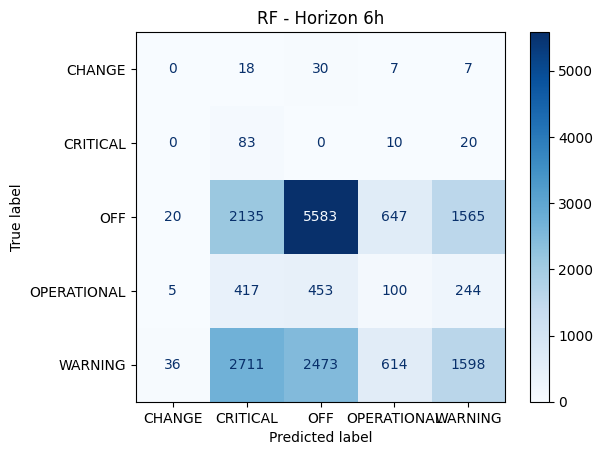

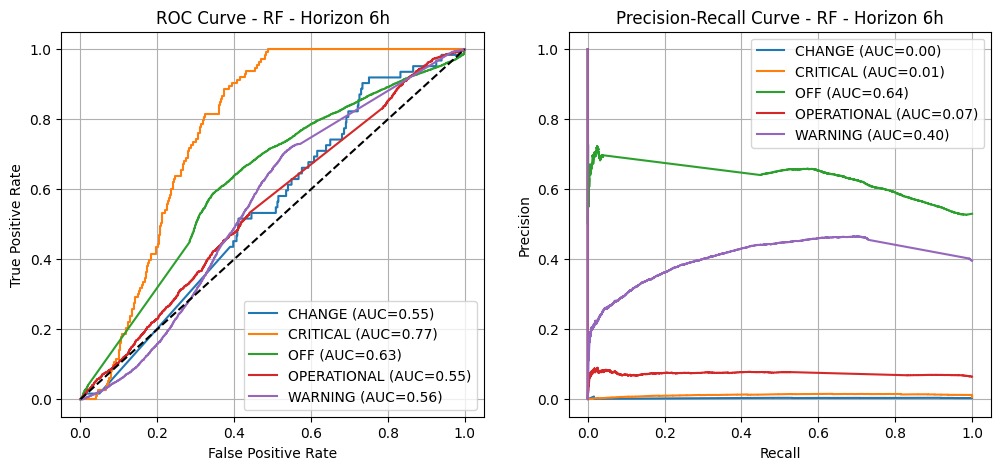


Cat | Acc: 0.4467 | Prec: 0.5432 | Rec: 0.4467 | F1: 0.4789 | AUC: 0.5978869911801115
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        62
    CRITICAL     0.0087    0.3009    0.0169       113
         OFF     0.6319    0.6319    0.6319      9950
 OPERATIONAL     0.0769    0.0427    0.0549      1219
     WARNING     0.5136    0.2710    0.3548      7432

    accuracy                         0.4467     18776
   macro avg     0.2462    0.2493    0.2117     18776
weighted avg     0.5432    0.4467    0.4789     18776



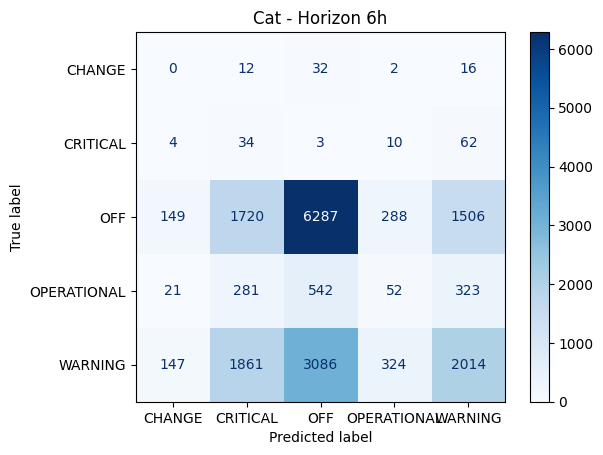

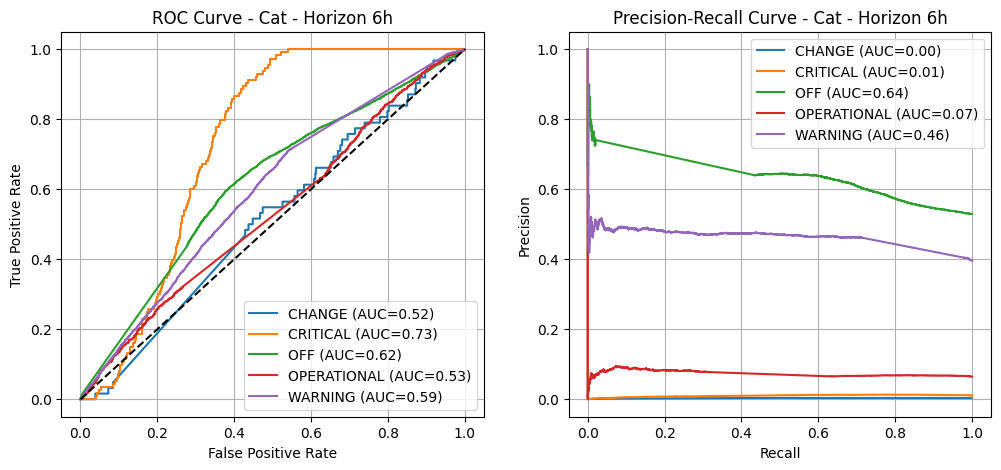


Voting | Acc: 0.5352 | Prec: 0.5282 | Rec: 0.5352 | F1: 0.5301 | AUC: 0.6055585107051836
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        62
    CRITICAL     0.0045    0.0354    0.0080       113
         OFF     0.6111    0.6306    0.6207      9950
 OPERATIONAL     0.0678    0.0098    0.0172      1219
     WARNING     0.5050    0.5057    0.5053      7432

    accuracy                         0.5352     18776
   macro avg     0.2377    0.2363    0.2303     18776
weighted avg     0.5282    0.5352    0.5301     18776



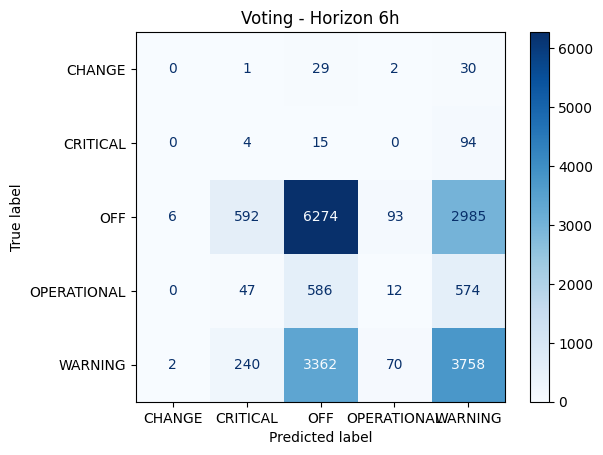

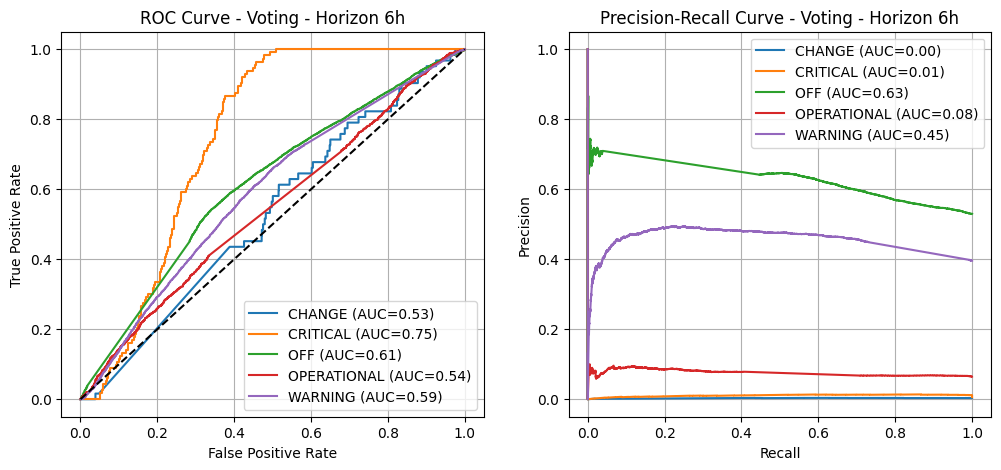


=== Horizon: 1d ===

XGB | Acc: 0.5849 | Prec: 0.5426 | Rec: 0.5849 | F1: 0.5547 | AUC: 0.545794568347907
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        63
    CRITICAL     0.0000    0.0000    0.0000       125
         OFF     0.6013    0.7543    0.6691      9540
 OPERATIONAL     0.1111    0.0008    0.0015      1320
     WARNING     0.5571    0.4899    0.5213      7728

    accuracy                         0.5849     18776
   macro avg     0.2539    0.2490    0.2384     18776
weighted avg     0.5426    0.5849    0.5547     18776



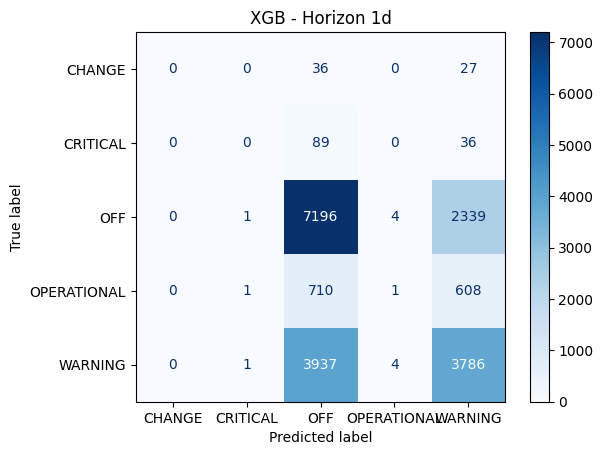

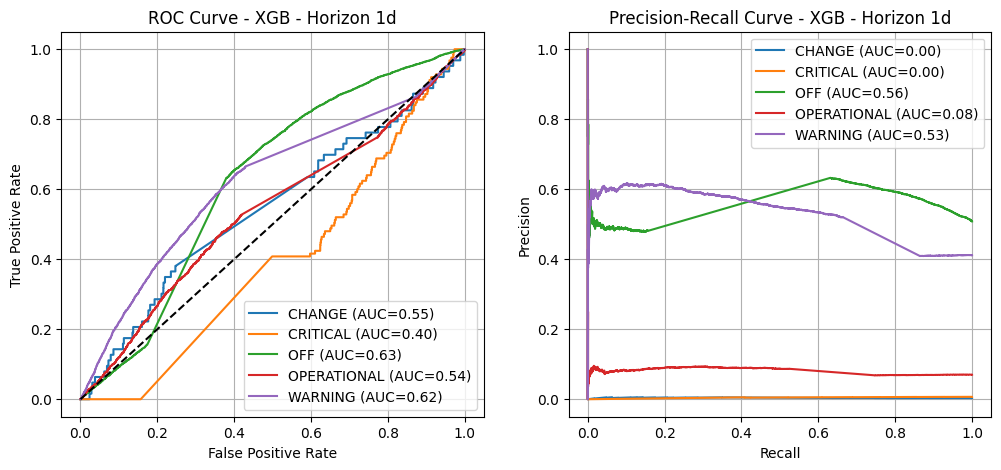

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 87619, number of used features: 30
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

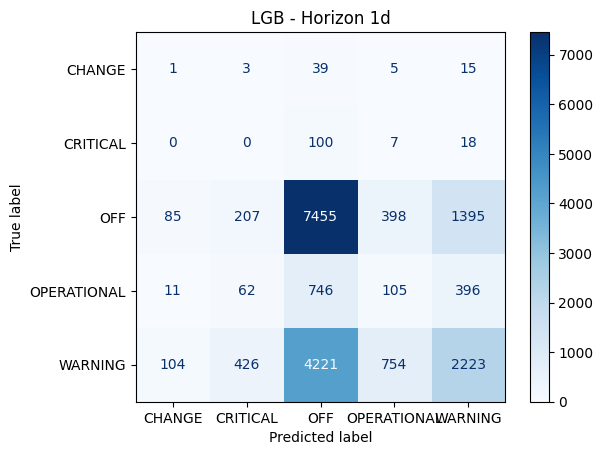

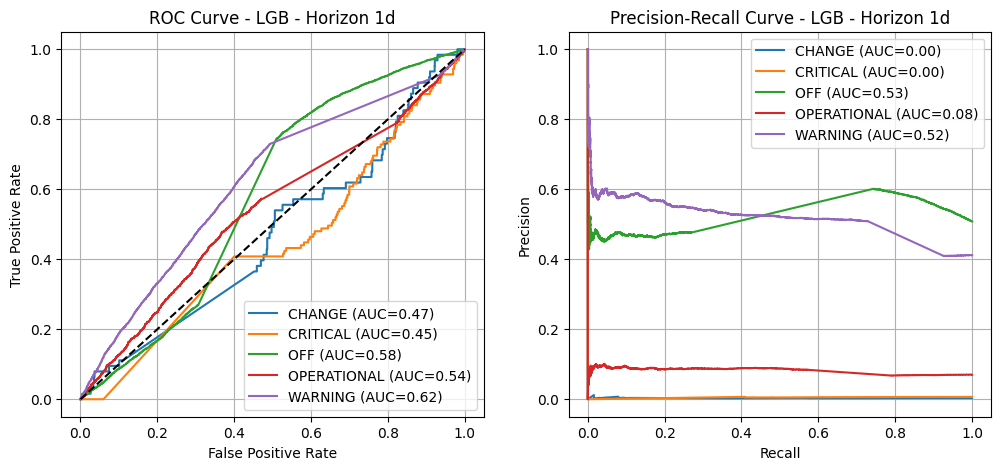


RF | Acc: 0.4731 | Prec: 0.5481 | Rec: 0.4731 | F1: 0.4657 | AUC: 0.5578087502556932
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        63
    CRITICAL     0.0000    0.0000    0.0000       125
         OFF     0.6063    0.7680    0.6776      9540
 OPERATIONAL     0.0768    0.0856    0.0810      1320
     WARNING     0.5702    0.1866    0.2812      7728

    accuracy                         0.4731     18776
   macro avg     0.2507    0.2080    0.2080     18776
weighted avg     0.5481    0.4731    0.4657     18776



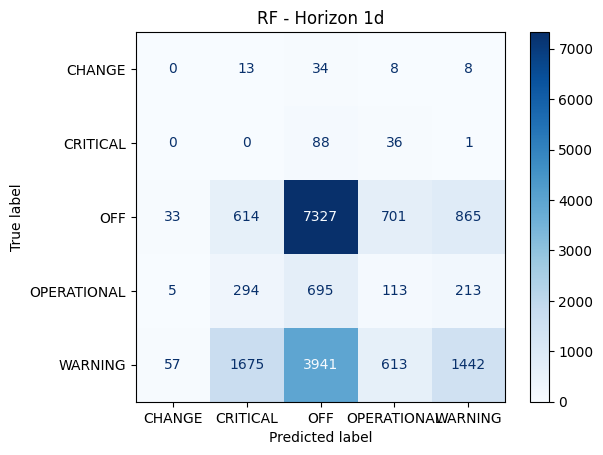

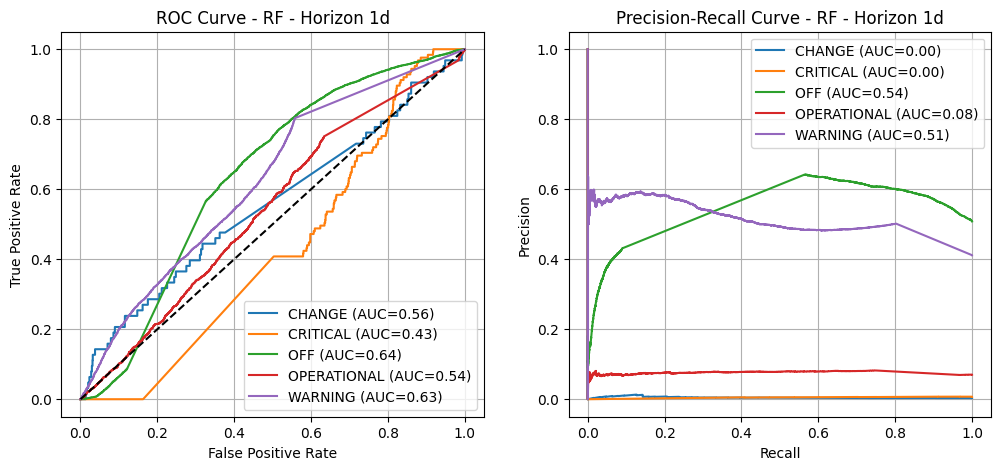


Cat | Acc: 0.4853 | Prec: 0.5369 | Rec: 0.4853 | F1: 0.4681 | AUC: 0.5342455554640825
              precision    recall  f1-score   support

      CHANGE     0.0059    0.0317    0.0100        63
    CRITICAL     0.0000    0.0000    0.0000       125
         OFF     0.6004    0.7948    0.6840      9540
 OPERATIONAL     0.0508    0.0167    0.0251      1320
     WARNING     0.5547    0.1949    0.2884      7728

    accuracy                         0.4853     18776
   macro avg     0.2424    0.2076    0.2015     18776
weighted avg     0.5369    0.4853    0.4681     18776



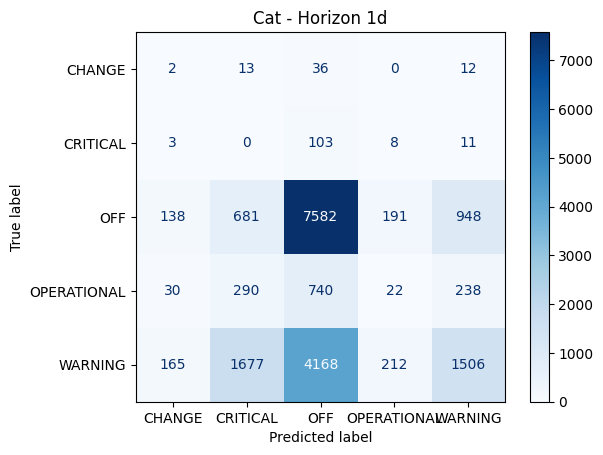

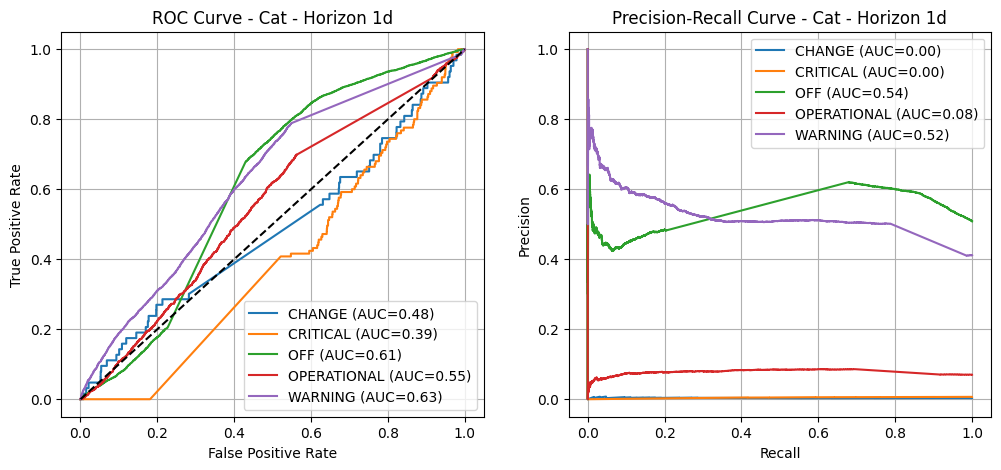


Voting | Acc: 0.5644 | Prec: 0.5410 | Rec: 0.5644 | F1: 0.5396 | AUC: 0.5470793590986089
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        63
    CRITICAL     0.0000    0.0000    0.0000       125
         OFF     0.5991    0.7778    0.6769      9540
 OPERATIONAL     0.1000    0.0114    0.0204      1320
     WARNING     0.5578    0.4092    0.4720      7728

    accuracy                         0.5644     18776
   macro avg     0.2514    0.2397    0.2339     18776
weighted avg     0.5410    0.5644    0.5396     18776



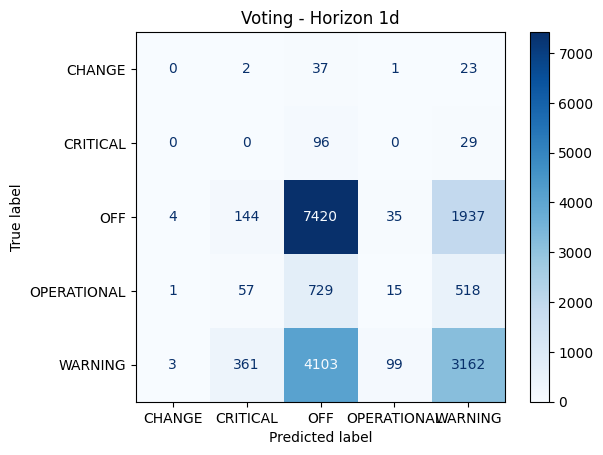

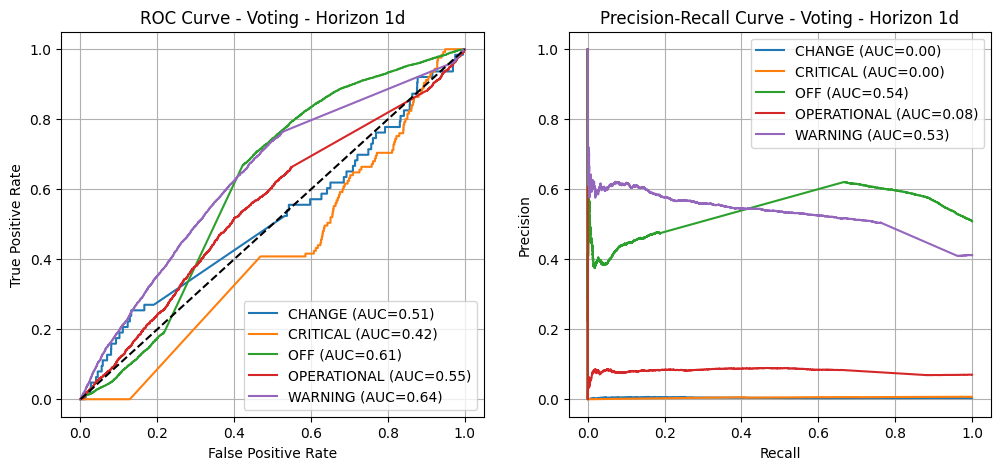


=== Horizon: 3d ===

XGB | Acc: 0.5525 | Prec: 0.5221 | Rec: 0.5525 | F1: 0.5224 | AUC: 0.5450198812992826
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        69
    CRITICAL     0.0000    0.0000    0.0000        60
         OFF     0.5882    0.7357    0.6537     10046
 OPERATIONAL     0.2857    0.0016    0.0032      1229
     WARNING     0.4806    0.4044    0.4392      7372

    accuracy                         0.5525     18776
   macro avg     0.2709    0.2283    0.2192     18776
weighted avg     0.5221    0.5525    0.5224     18776



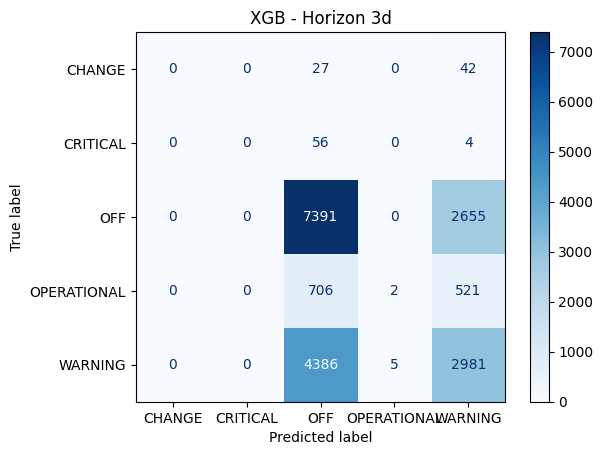

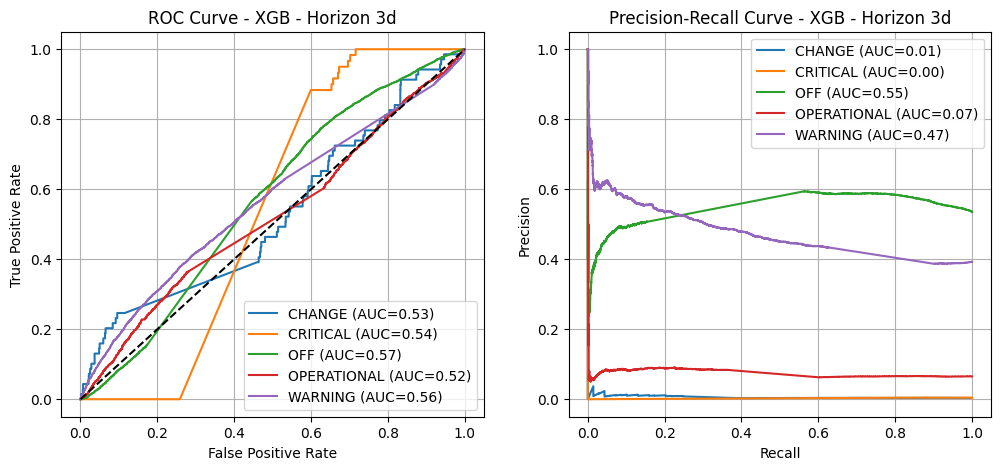

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 87619, number of used features: 30
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

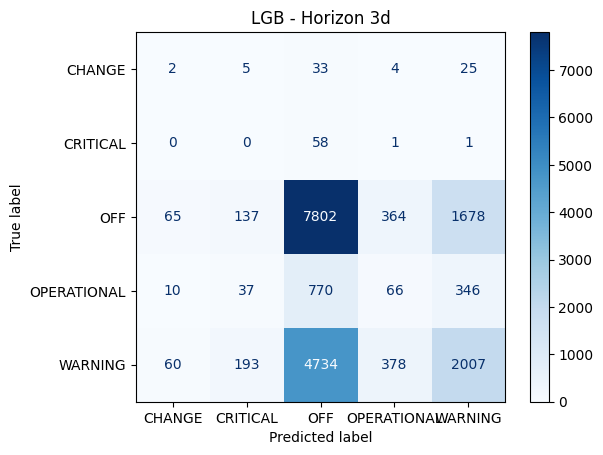

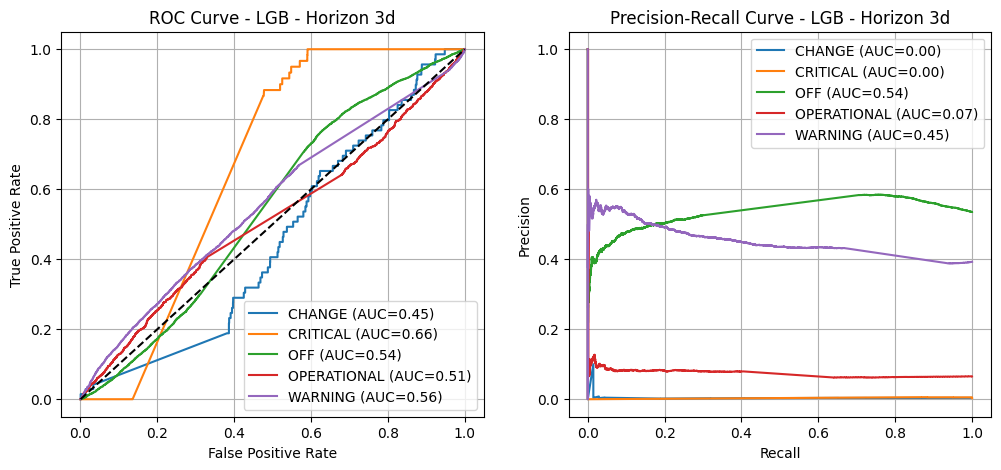


RF | Acc: 0.5509 | Prec: 0.5535 | Rec: 0.5509 | F1: 0.5169 | AUC: 0.5405733896888187
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        69
    CRITICAL     0.0000    0.0000    0.0000        60
         OFF     0.5969    0.8339    0.6957     10046
 OPERATIONAL     0.0597    0.0155    0.0246      1229
     WARNING     0.5864    0.2641    0.3642      7372

    accuracy                         0.5509     18776
   macro avg     0.2486    0.2227    0.2169     18776
weighted avg     0.5535    0.5509    0.5169     18776



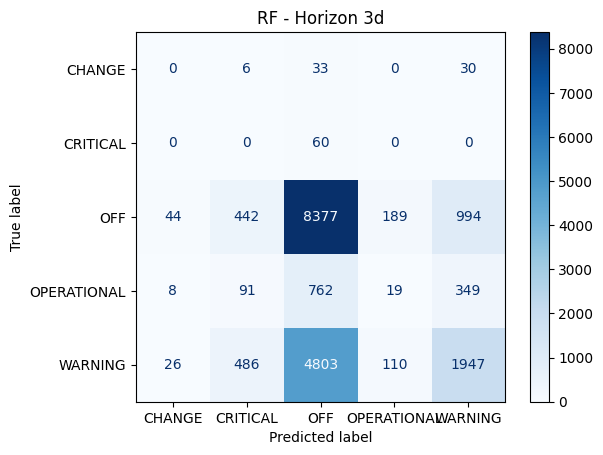

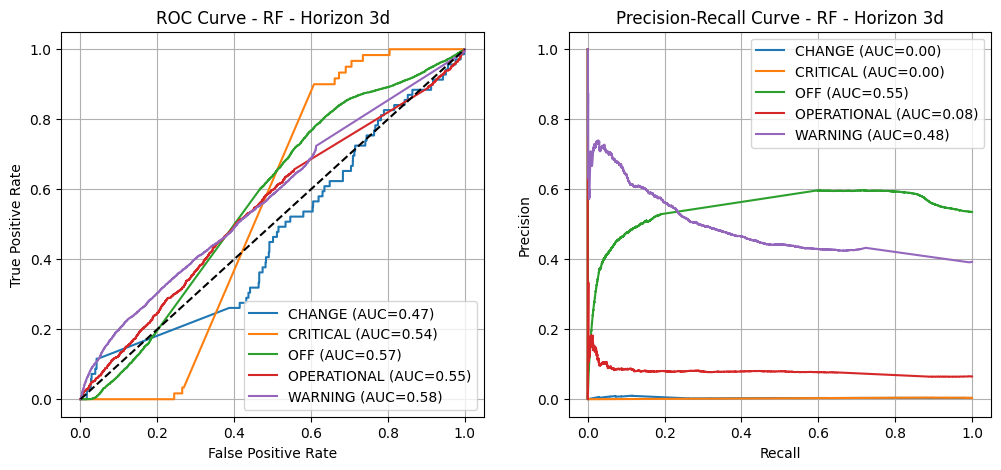


Cat | Acc: 0.5193 | Prec: 0.5389 | Rec: 0.5193 | F1: 0.4899 | AUC: 0.533258868080263
              precision    recall  f1-score   support

      CHANGE     0.0090    0.0435    0.0149        69
    CRITICAL     0.0000    0.0000    0.0000        60
         OFF     0.5905    0.8083    0.6824     10046
 OPERATIONAL     0.0554    0.0138    0.0221      1229
     WARNING     0.5584    0.2184    0.3140      7372

    accuracy                         0.5193     18776
   macro avg     0.2427    0.2168    0.2067     18776
weighted avg     0.5389    0.5193    0.4899     18776



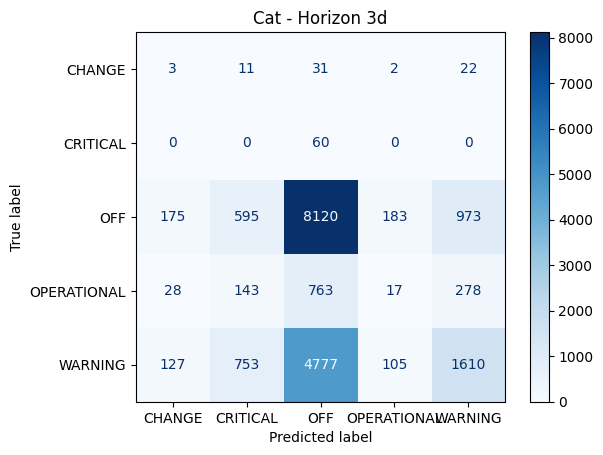

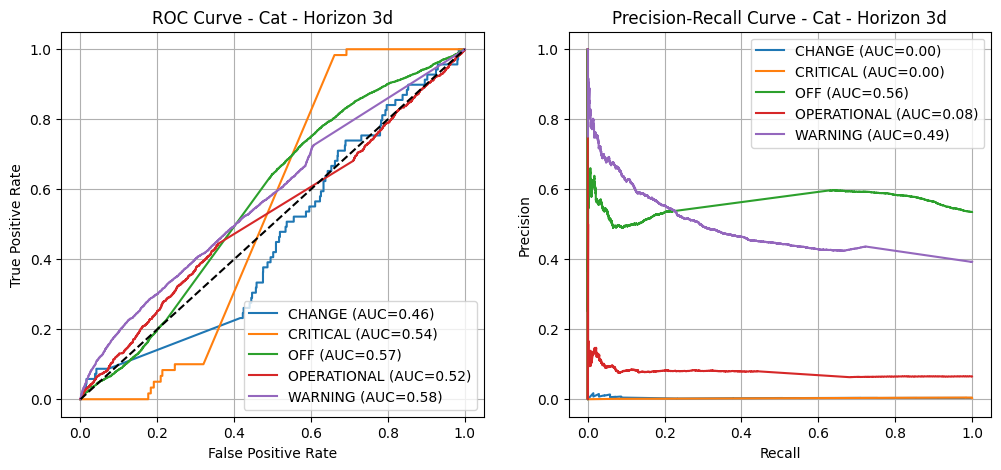


Voting | Acc: 0.5615 | Prec: 0.5221 | Rec: 0.5615 | F1: 0.5242 | AUC: 0.5437850090993896
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        69
    CRITICAL     0.0000    0.0000    0.0000        60
         OFF     0.5893    0.7947    0.6768     10046
 OPERATIONAL     0.1224    0.0049    0.0094      1229
     WARNING     0.5061    0.3462    0.4111      7372

    accuracy                         0.5615     18776
   macro avg     0.2436    0.2292    0.2195     18776
weighted avg     0.5221    0.5615    0.5242     18776



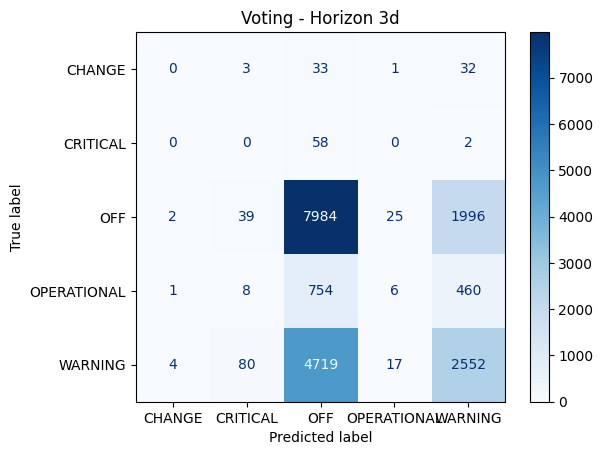

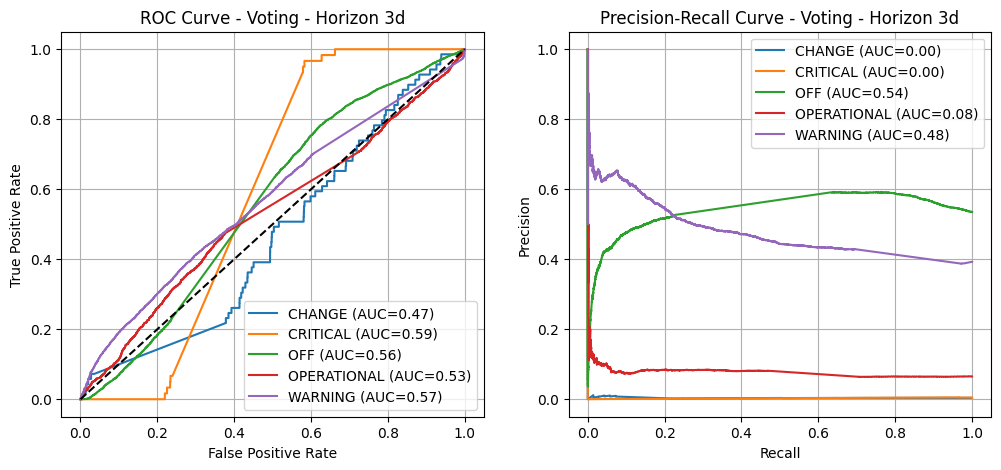


=== Horizon: 5d ===

XGB | Acc: 0.5121 | Prec: 0.4692 | Rec: 0.5121 | F1: 0.4705 | AUC: 0.5306885404239179
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        64
    CRITICAL     0.0000    0.0000    0.0000        42
         OFF     0.5238    0.7635    0.6213      9428
 OPERATIONAL     0.0000    0.0000    0.0000      1239
     WARNING     0.4837    0.3021    0.3719      8003

    accuracy                         0.5121     18776
   macro avg     0.2015    0.2131    0.1986     18776
weighted avg     0.4692    0.5121    0.4705     18776



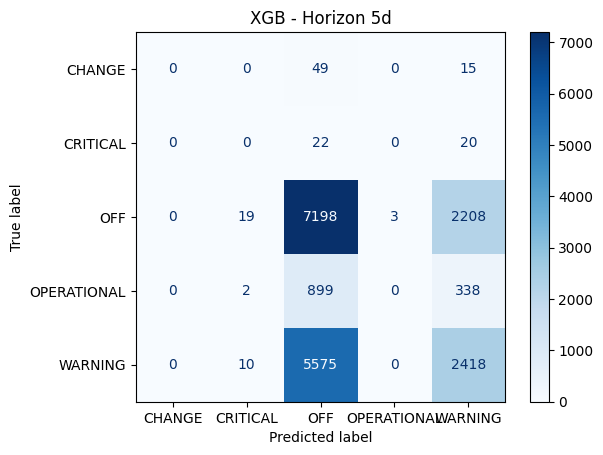

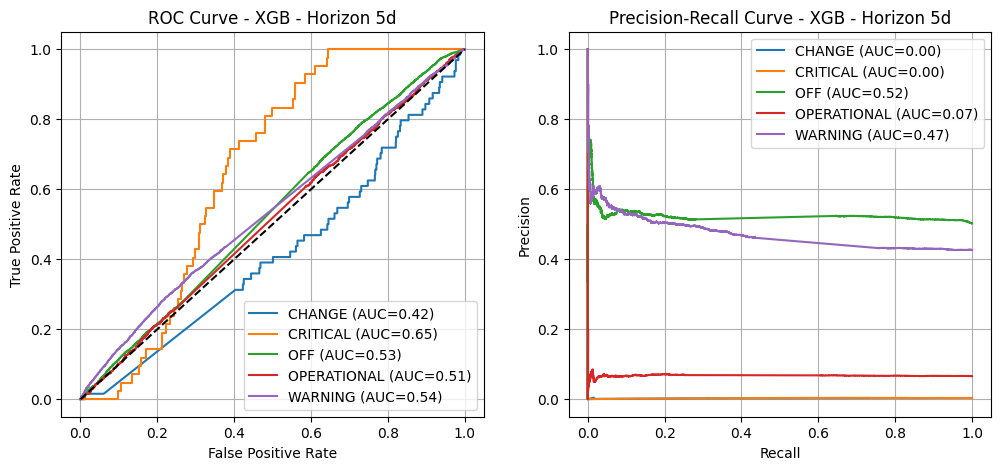

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 87619, number of used features: 30
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

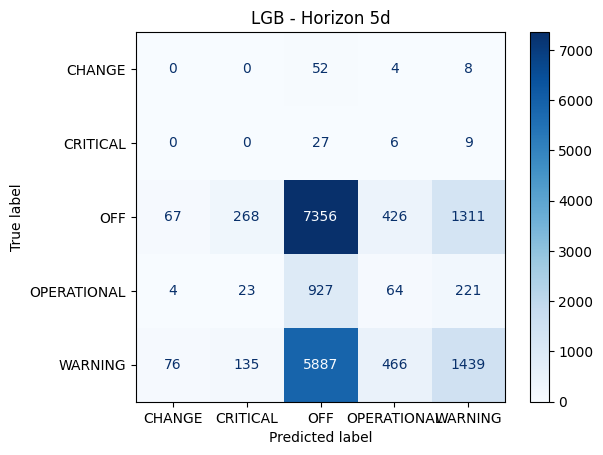

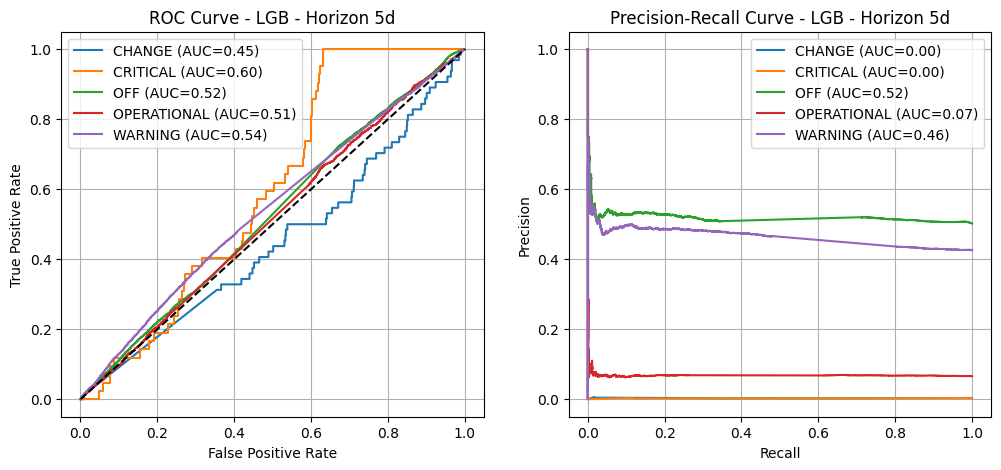


RF | Acc: 0.4526 | Prec: 0.5027 | Rec: 0.4526 | F1: 0.4372 | AUC: 0.5773740148350394
              precision    recall  f1-score   support

      CHANGE     0.0050    0.0156    0.0076        64
    CRITICAL     0.0000    0.0000    0.0000        42
         OFF     0.5285    0.7162    0.6082      9428
 OPERATIONAL     0.0639    0.0872    0.0737      1239
     WARNING     0.5468    0.2045    0.2977      8003

    accuracy                         0.4526     18776
   macro avg     0.2288    0.2047    0.1974     18776
weighted avg     0.5027    0.4526    0.4372     18776



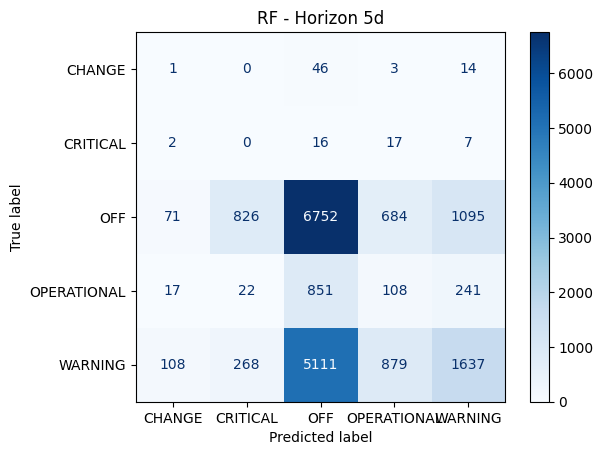

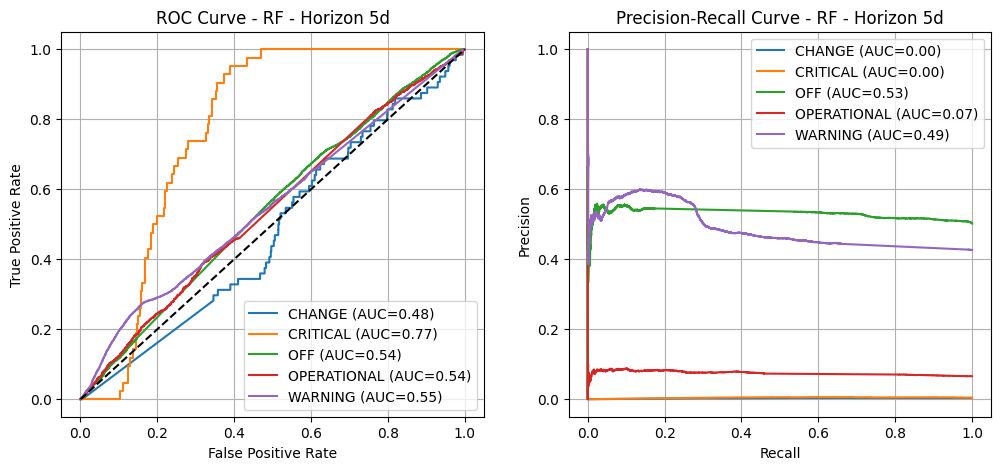


Cat | Acc: 0.4793 | Prec: 0.5089 | Rec: 0.4793 | F1: 0.4517 | AUC: 0.532955634101044
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        64
    CRITICAL     0.0000    0.0000    0.0000        42
         OFF     0.5264    0.7606    0.6222      9428
 OPERATIONAL     0.0594    0.0250    0.0352      1239
     WARNING     0.5647    0.2245    0.3213      8003

    accuracy                         0.4793     18776
   macro avg     0.2301    0.2020    0.1957     18776
weighted avg     0.5089    0.4793    0.4517     18776



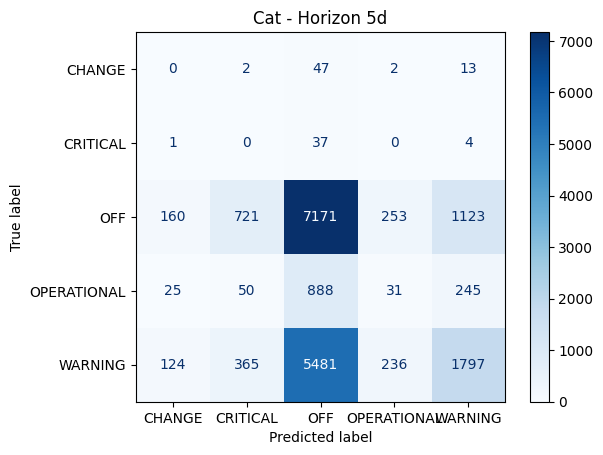

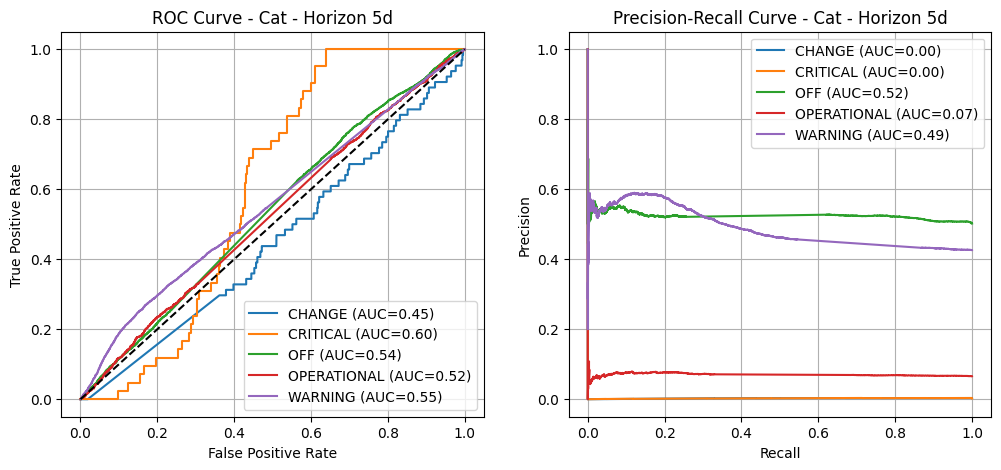


Voting | Acc: 0.5068 | Prec: 0.4808 | Rec: 0.5068 | F1: 0.4645 | AUC: 0.5465253371992711
              precision    recall  f1-score   support

      CHANGE     0.0000    0.0000    0.0000        64
    CRITICAL     0.0000    0.0000    0.0000        42
         OFF     0.5227    0.7779    0.6253      9428
 OPERATIONAL     0.0870    0.0048    0.0092      1239
     WARNING     0.4987    0.2718    0.3518      8003

    accuracy                         0.5068     18776
   macro avg     0.2217    0.2109    0.1973     18776
weighted avg     0.4808    0.5068    0.4645     18776



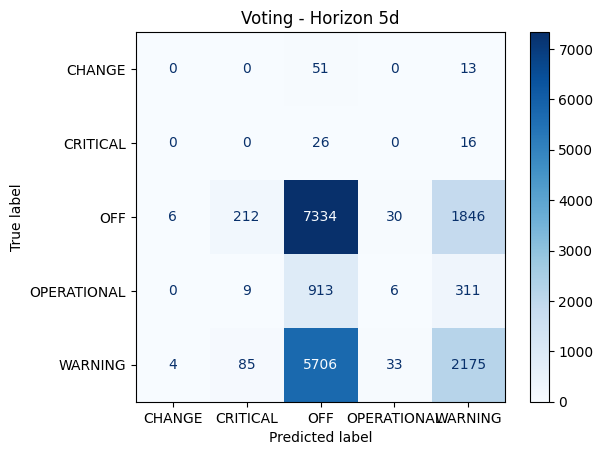

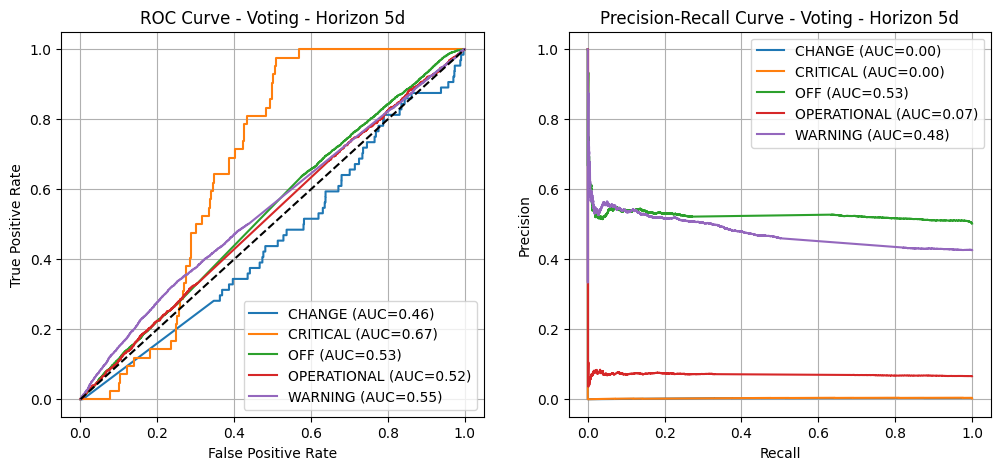

Horizon   Model  Accuracy  Precision    Recall        F1       AUC
0       1h     XGB  0.737484   0.707762  0.737484  0.710143  0.802996
1       1h     LGB  0.674318   0.689132  0.674318  0.677843  0.789390
2       1h      RF  0.654399   0.713086  0.654399  0.679313  0.797679
3       1h     Cat  0.665530   0.708889  0.665530  0.679218  0.803028
4       1h  Voting  0.725075   0.699105  0.725075  0.708004  0.806668
5       6h     XGB  0.551449   0.520609  0.551449  0.532210  0.605731
6       6h     LGB  0.483117   0.505575  0.483117  0.489241  0.589923
7       6h      RF  0.392203   0.535482  0.392203  0.441645  0.611992
8       6h     Cat  0.446687   0.543202  0.446687  0.478944  0.597887
9       6h  Voting  0.535151   0.528200  0.535151  0.530119  0.605559
10      1d     XGB  0.584949   0.542607  0.584949  0.554676  0.545795
11      1d     LGB  0.521091   0.533474  0.521091  0.503912  0.531355
12      1d      RF  0.473051   0.548135  0.473051  0.465727  0.557809
13      1d     Cat  0.485300   0.536941  0.485300  0.468056  0.534246
14      1d  Voting  0.564391   0.541009  0.564391  0.539630  0.547079
15      3d     XGB  0.552514   0.522089  0.552514  0.522422  0.545020
16      3d     LGB  0.526044   0.511195  0.526044  0.498332  0.545954
17      3d      RF  0.550863   0.553516  0.550863  0.516852  0.540573
18      3d     Cat  0.519280   0.538865  0.519280  0.489922  0.533259
19      3d  Voting  0.561461   0.522052  0.561461  0.524152  0.543785
20      5d     XGB  0.512143   0.469163  0.512143  0.470506  0.530689
21      5d     LGB  0.471826   0.468867  0.471826  0.427446  0.524776
22      5d      RF  0.452599   0.502652  0.452599  0.437173  0.577374
23      5d     Cat  0.479282   0.508927  0.479282  0.451687  0.532956
24      5d  Voting  0.506764   0.480801  0.506764  0.464543  0.546525

In [44]:

# Training & Evaluation loop with actual status names
all_metrics = []

for h in horizons:
    print(f"\n=== Horizon: {h} ===")
    
    y_h = resampled[f'status_future_{h}']
    le_h = LabelEncoder()
    y_encoded = le_h.fit_transform(y_h)
    label_names = le_h.classes_  # actual status names
    
    X_train, X_val, X_test, y_train, y_val, y_test = time_based_split(X_final, pd.Series(y_encoded))
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted")
        
        auc_score = None
        if y_proba is not None:
            try:
                if len(label_names) == 2:
                    auc_score = roc_auc_score(y_test, y_proba[:, 1])
                else:
                    auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")
            except Exception:
                auc_score = None
        
        all_metrics.append({
            "Horizon": h,
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "AUC": auc_score
        })
        
        print(f"\n{name} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {auc_score}")
        print(classification_report(y_test, y_pred, target_names=label_names, digits=4))
        
        plot_confusion_matrix(y_test, y_pred, labels=label_names, title=f"{name} - Horizon {h}")
        if y_proba is not None:
            plot_roc_pr_curves(y_test, y_proba, label_names, title=f"{name} - Horizon {h}")

metrics_df = pd.DataFrame(all_metrics)
metrics_df



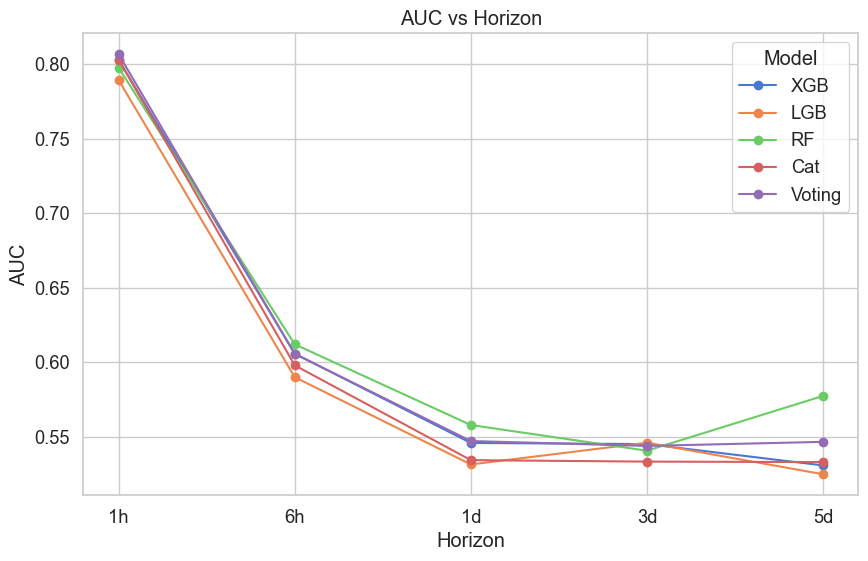

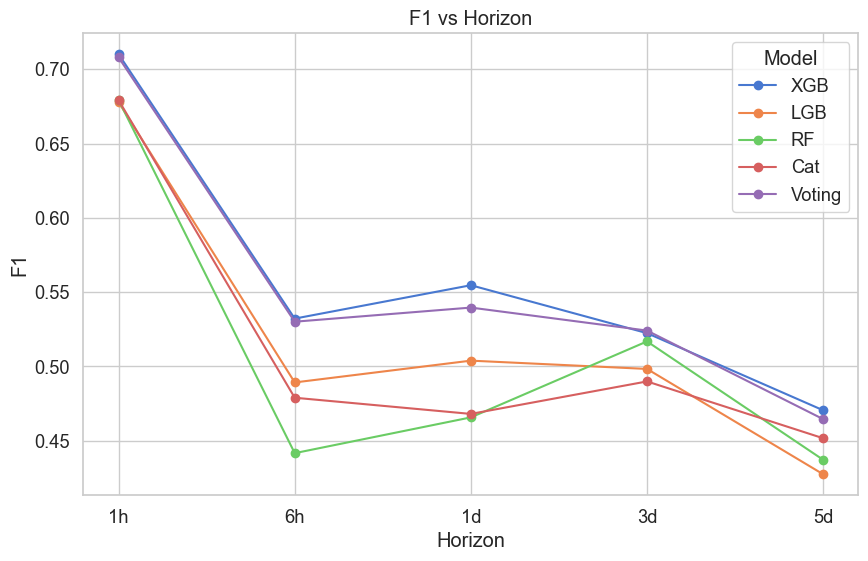

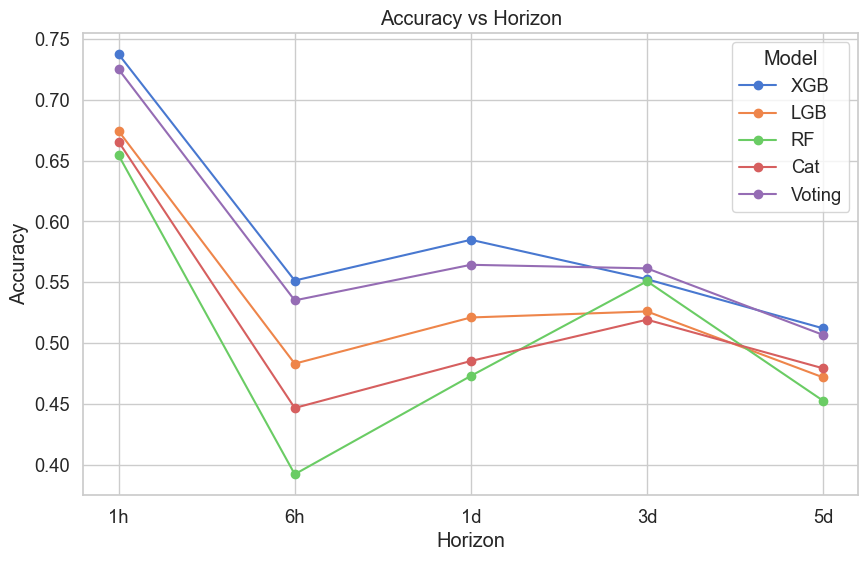

In [45]:
# Set seaborn style for clarity
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Metrics to plot
metrics_to_plot = ["AUC", "F1", "Accuracy"]

for metric in metrics_to_plot:
    plt.figure(figsize=(10,6))
    
    for model in metrics_df["Model"].unique():
        df_model = metrics_df[metrics_df["Model"] == model]
        plt.plot(df_model["Horizon"], df_model[metric], marker='o', label=model)
    
    plt.title(f"{metric} vs Horizon")
    plt.xlabel("Horizon")
    plt.ylabel(metric)
    plt.xticks(df_model["Horizon"].unique())  # show all horizons on x-axis
    plt.legend(title="Model")
    plt.grid(True)
    plt.show()

## Deploy

### Save Artifacts (Model + Preprocessor)

In [46]:
# Pick best model for 1h (example: Voting)
best_model = models["XGB"]

# Save model and preprocessing objects
joblib.dump(best_model, "pump_model_1h.joblib")
joblib.dump(top_features, "selected_features_1h.joblib")
joblib.dump(le_h, "label_encoder_1h.joblib")
print("Artifacts saved successfully!")


Artifacts saved successfully!


In [47]:
def preprocess_new_data(new_df, horizons, top_features):
    """
    Preprocess incoming sensor data for inference.
    Expects columns: Time, flow, pressure, level, NDE_motor, DE_motor, DE_pump, NDE_pump, Coupling, pump
    """
    # --- Ensure datetime ---
    new_df["Time"] = pd.to_datetime(new_df["Time"], errors="coerce")
    new_df = new_df.set_index("Time")

    # --- Resample to 1min ---
    numeric_cols = ['flow', 'pressure', 'level', 'NDE_motor', 'DE_motor', 'DE_pump', 'NDE_pump', 'Coupling']
    resampled = new_df.resample('1min').agg(
        {col: ['mean', 'std', 'min', 'max'] for col in numeric_cols} |
        {'pump': 'last'}
    )

    resampled.columns = [
        '_'.join(col).strip() if isinstance(col, tuple) else col
        for col in resampled.columns
    ]

    # --- Outlier clipping ---
    def remove_outliers_iqr(series, factor=1.5):
        Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - factor*IQR, Q3 + factor*IQR
        return series.clip(lower, upper)

    for col in resampled.columns:
        if any(sensor in col for sensor in numeric_cols):
            resampled[col] = remove_outliers_iqr(resampled[col])

    # --- Rolling stats ---
    windows = [3, 5, 10]
    for col in [c for c in resampled.columns if any(sensor in c for sensor in numeric_cols)]:
        for w in windows:
            resampled[f"{col}_roll_mean_{w}"] = resampled[col].rolling(w, min_periods=1).mean()
            resampled[f"{col}_roll_std_{w}"]  = resampled[col].rolling(w, min_periods=1).std()
            resampled[f"{col}_roll_min_{w}"]  = resampled[col].rolling(w, min_periods=1).min()
            resampled[f"{col}_roll_max_{w}"]  = resampled[col].rolling(w, min_periods=1).max()

    # --- Delta & slope ---
    for col in [c for c in resampled.columns if any(sensor in c for sensor in numeric_cols)]:
        resampled[f"{col}_delta"] = resampled[col].diff()
        resampled[f"{col}_slope"] = resampled[col].diff().rolling(5, min_periods=1).mean()

    # --- FFT features (vibration) ---
    def compute_fft(series, fs=1/60):
        series = series.dropna()
        N = len(series)
        if N < 10: return np.nan
        yf = np.abs(rfft(series))
        xf = rfftfreq(N, fs)
        return xf[np.argmax(yf)]

    vib_cols = ['NDE_motor', 'DE_motor', 'DE_pump', 'NDE_pump', 'Coupling']
    for col in vib_cols:
        colname = col + "_mean"
        if colname in resampled:
            resampled[f"{col}_fft_freq"] = resampled[colname].rolling(60, min_periods=30).apply(compute_fft, raw=False)

    # --- Fill missing ---
    resampled = resampled.fillna(method="bfill").fillna(method="ffill")

    # --- Keep only training features ---
    X_new = resampled[top_features].iloc[[-1]]  # take latest row
    return X_new


In [51]:
# Load artifacts
model = joblib.load("pump_model_1h.joblib")
top_features = joblib.load("selected_features_1h.joblib")
le = joblib.load("label_encoder_1h.joblib")

# Example incoming data
sample_data = pd.DataFrame([{
    "Time": "2025-08-26 10:00:00",
    "flow": 7.0,
    "pressure": 14.0,
    "level": 4.0,
    "NDE_motor": 1.425895,
    "DE_motor": 0.809613,
    "DE_pump": 1.515767,
    "NDE_pump": 10.925454,
    "Coupling": 10.712472,
    "pump": "Gunhill"
}])							

# Preprocess
X_new = preprocess_new_data(sample_data, horizons, top_features)

# Predict
pred_class = model.predict(X_new)[0]
pred_prob = model.predict_proba(X_new)[0]

print("Predicted status in 1h:", le.inverse_transform([pred_class])[0])
print("Probabilities:", dict(zip(le.classes_, pred_prob.round(3))))


Predicted status in 1h: CRITICAL
Probabilities: {'CHANGE': 0.129, 'CRITICAL': 0.348, 'OFF': 0.093, 'OPERATIONAL': 0.21, 'WARNING': 0.221}
